In [ ]:
# # YOLOv8 (Ultralytics)
# !pip install ultralytics

# # Image processing
# !pip install opencv-python matplotlib pillow tqdm

# # For working with JSON and data
# !pip install pycocotools


import sys
!{sys.executable} -m pip install ultralytics opencv-python matplotlib pillow tqdm pycocotools

In [1]:
# Standard libraries
import os, json, shutil
from pathlib import Path
from tqdm import tqdm

# Data handling + visualization
import cv2
import matplotlib.pyplot as plt

# Ultralytics YOLO
from ultralytics import YOLO

In [2]:
def coco_to_yolo_single_class(coco_json, images_dir, out_images_dir, out_labels_dir,
                              class_id=0, copy_images=True):
    out_images_dir = Path(out_images_dir); out_images_dir.mkdir(parents=True, exist_ok=True)
    out_labels_dir = Path(out_labels_dir); out_labels_dir.mkdir(parents=True, exist_ok=True)

    with open(coco_json, 'r') as f:
        coco = json.load(f)

    # index helpers
    img_by_id = {im['id']: im for im in coco['images']}
    anns_by_img = {}
    for a in coco['annotations']:
        anns_by_img.setdefault(a['image_id'], []).append(a)

    # walk through images
    for img_id, im in tqdm(img_by_id.items(), desc=f"Converting {Path(coco_json).stem}"):
        file_name = im['file_name']
        # robust path join (handles subfolders in file_name)
        src = (Path(images_dir) / file_name).resolve()
        if not src.exists():
            # also try if file_name is already absolute/relative to images_dir’s parent
            src = Path(file_name)
        if not src.exists():
            # last resort: try basename directly under images_dir
            src = Path(images_dir) / Path(file_name).name

        if not src.exists():
            print(f"[WARN] Image missing: {file_name}")
            continue

        # copy image
        dst_img = out_images_dir / Path(src).name
        if copy_images and str(src.resolve()) != str(dst_img.resolve()):
            shutil.copy2(src, dst_img)
        else:
            dst_img = src  # if not copying, we’ll just point to original

        W, H = im['width'], im['height']
        label_path = out_labels_dir / (dst_img.stem + ".txt")
        lines = []
        for a in anns_by_img.get(img_id, []):
            # use bbox from COCO: [x_min, y_min, w, h] in pixels
            x, y, w, h = a['bbox']
            xc = (x + w/2.0) / W
            yc = (y + h/2.0) / H
            nw = w / W
            nh = h / H
            # clamp
            xc = min(max(xc, 0), 1); yc = min(max(yc, 0), 1)
            nw = min(max(nw, 0), 1); nh = min(max(nh, 0), 1)
            lines.append(f"{class_id} {xc:.6f} {yc:.6f} {nw:.6f} {nh:.6f}")
        # write .txt (if no objects, write empty file or skip; YOLO allows missing label for no-object)
        if lines:
            with open(label_path, "w") as f:
                f.write("\n".join(lines))
        else:
            # no drone in this image → optional: create empty file or leave absent
            pass

In [2]:
ROOT = Path("uav")

In [11]:
RAW = ROOT / "raw"
DET = ROOT / "detectors"

# ---- define your actual paths here ----
cfg = {
    "city": {
        "train_json": RAW/r"D:\SIDD-main\SIDD-main\city\coco格式\cococity\annotations\instances_train2017.json",
        "val_json":   RAW/r"D:\SIDD-main\SIDD-main\city\coco格式\cococity\annotations\instances_val2017.json",
        "images_root": RAW/r"D:\SIDD-main\SIDD-main\city\coco格式\cococity\annotations",   # base to resolve file_name paths
    },
    "mountain": {
        "train_json": RAW/r"D:\SIDD-main\SIDD-main\moutain\coco格式\moutain2coco\annotations\instances_train2017.json",
        "val_json":   RAW/r"D:\SIDD-main\SIDD-main\moutain\coco格式\moutain2coco\annotations\instances_val2017.json",
        "images_root": RAW/r"D:\SIDD-main\SIDD-main\moutain\coco格式\moutain2coco\annotations",   # base to resolve file_name paths
    },
    "sea": {
        "train_json": RAW/r"D:\SIDD-main\SIDD-main\sea\coco格式\sea2coco\annotations\instances_train2017.json",
        "val_json":   RAW/r"D:\SIDD-main\SIDD-main\sea\coco格式\sea2coco\annotations\instances_val2017.json",
        "images_root": RAW/r"D:\SIDD-main\SIDD-main\sea\coco格式\sea2coco\annotations",   # base to resolve file_name paths
    },
    "sky": {
        "train_json": RAW/r"D:\SIDD-main\SIDD-main\sky\coco格式\sky2coco\annotations\instances_train2017.json",
        "val_json":   RAW/r"D:\SIDD-main\SIDD-main\sky\coco格式\sky2coco\annotations\instances_val2017.json",
        "images_root": RAW/r"D:\SIDD-main\SIDD-main\sky\coco格式\sky2coco\annotations",   # base to resolve file_name paths
    },
}

for env, d in cfg.items():
    # output dirs
    out_img_tr = DET/env/"images/train"
    out_lbl_tr = DET/env/"labels/train"
    out_img_va = DET/env/"images/val"
    out_lbl_va = DET/env/"labels/val"

    coco_to_yolo_single_class(d["train_json"], d["images_root"], out_img_tr, out_lbl_tr, class_id=0)
    coco_to_yolo_single_class(d["val_json"],   d["images_root"], out_img_va, out_lbl_va, class_id=0)

Converting instances_val2017: 100%|█████████████████████████████████████████████████| 156/156 [00:00<00:00, 176.38it/s]


In [6]:
DET = Path(r"D:\SIDD-main\detectors")
CLS = ROOT / "classifier"

In [5]:
for split in ["train","val"]:
    for env in ["city","mountain","sea","sky"]:
        (CLS/split/env).mkdir(parents=True, exist_ok=True)

def copy_tree(src_dir, dst_dir):
    src_dir = Path(src_dir); dst_dir = Path(dst_dir)
    dst_dir.mkdir(parents=True, exist_ok=True)
    for p in src_dir.rglob("*"):
        if p.suffix.lower() in [".jpg",".jpeg",".png",".bmp",".tif",".tiff"]:
            shutil.copy2(p, dst_dir / p.name)

# copy images into classifier dataset
for env in ["city","mountain","sea","sky"]:
    copy_tree(DET/env/"images/train", CLS/"train"/env)
    copy_tree(DET/env/"images/val",   CLS/"val"/env)

In [4]:
from ultralytics import YOLO
from pathlib import Path
import torch, gc

def train_detector(env, epochs=10, imgsz=640, batch=8):
    env_path = DET / Path(env)   # ensure it's a Path object
    data_yaml = env_path / "data.yaml"
    
    data_yaml.write_text(f"""# {env} drone detector
path: {env_path.as_posix()}
train: images/train
val: images/val
names:
  0: drone
""")
    
    model = YOLO("yolov8n.pt")  # load pretrained YOLOv8n
    results = model.train(
        data=str(data_yaml),
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=20,
        device=0    # explicitly use GPU:0
    )

    # cleanup after training
    del model
    gc.collect()
    torch.cuda.empty_cache()

    return results

# Train detectors for each environment
for env in ["city","mountain","sea","sky"]:
    train_detector(env, epochs=10, imgsz=640, batch=8)

Ultralytics 8.3.188  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\SIDD-main\detectors\city\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train14, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plo

In [8]:
cls_model = YOLO("yolov8n-cls.pt")
cls_results = cls_model.train(
    data=str(CLS),  
    epochs=20,
    imgsz=224,      
    batch=64,
    device=0
)

Ultralytics 8.3.188  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=uav\classifier, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

In [9]:
import cv2
from ultralytics import YOLO

# load classifier + 4 detectors (update paths to your best.pt files)
cls = YOLO("runs/classify/train/weights/best.pt")

det_paths = {
    "city":     r"C:\Users\HP\runs\detect\train-city\weights\best.pt",
    "mountain": r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt",
    "sea":      r"C:\Users\HP\runs\detect\train-sea\weights\best.pt",
    "sky":      r"C:\Users\HP\runs\detect\train-sky\weights\best.pt",
}
det_models = {k: YOLO(v) for k,v in det_paths.items()}

ENV_NAMES = ["city","mountain","sea","sky"]

def highlight_box(img, box, alpha=0.25):
    # box = [x1,y1,x2,y2]
    overlay = img.copy()
    x1,y1,x2,y2 = map(int, box)
    cv2.rectangle(overlay, (x1,y1), (x2,y2), (0,255,0), -1)  # filled
    return cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

def detect_uav(image_path, conf_thres=0.25, iou_thres=0.5, save_path="out.jpg"):
    # 1) environment classification
    cls_res = cls(image_path)[0]
    top_id = int(cls_res.probs.top1)
    env = ENV_NAMES[top_id]
    env_conf = float(cls_res.probs.top1conf)

    # 2) route to detector
    det = det_models[env]
    det_res = det(image_path, conf=conf_thres, iou=iou_thres)[0]

    # 3) draw results
    img = cv2.imread(str(image_path))
    if len(det_res.boxes) == 0:
        # No drone
        cv2.putText(img, f"No UAV ({env}, {env_conf:.2f})", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
        cv2.imwrite(save_path, img)
        return {"env": env, "env_conf": env_conf, "detections": 0, "out": save_path}

    for b in det_res.boxes:
        x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
        conf = float(b.conf[0])
        # translucent highlight
        img = highlight_box(img, [x1,y1,x2,y2], alpha=0.25)
        # bbox outline + label
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img, f"drone {conf:.2f} [{env}]", (x1, max(20,y1-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)

    cv2.imwrite(save_path, img)
    return {"env": env, "env_conf": env_conf, "detections": len(det_res.boxes), "out": save_path}


In [15]:
# import cv2
# import matplotlib.pyplot as plt
# from ultralytics import YOLO

# # Load the trained classifier
# cls = YOLO(r"C:\Users\HP\runs\classify\train\weights\best.pt")

# # Load the trained detectors
# det_paths = {
#     "city": r"C:\Users\HP\runs\detect\train-city\weights\best.pt",
#     "mountain": r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt",
#     "sea": r"C:\Users\HP\runs\detect\train-sea\weights\best.pt",
#     "sky": r"C:\Users\HP\runs\detect\train-sky\weights\best.pt"
# }
# det_models = {k: YOLO(v) for k,v in det_paths.items()}

# def detect_uav(image_path):
#     # Step 1: Classify environment
#     env_result = cls(image_path)
#     env = env_result[0].probs.top1  # index of best class
#     env_name = list(det_paths.keys())[env]

#     # Step 2: Run detector for that environment
#     det_result = det_models[env_name](image_path)

#     # Step 3: Plot detections
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     for r in det_result[0].boxes.xyxy:
#         x1, y1, x2, y2 = map(int, r)
#         cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

#     plt.figure(figsize=(10, 8))
#     plt.imshow(img)
#     plt.axis("off")
#     plt.title(f"Environment: {env_name}")
#     plt.show()

# # Example usage
# detect_uav(r"D:\SIDD-main\SIDD-main\city\coco格式\cococity\train2017\303.jpg")  # replace with your test image path


image 1/1 D:\SIDD-main\SIDD-main\city\coco\cococity\train2017\303.jpg: 224x224 city 1.00, mountain 0.00, sea 0.00, sky 0.00, 6.8ms
Speed: 11.7ms preprocess, 6.8ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 D:\SIDD-main\SIDD-main\city\coco\cococity\train2017\303.jpg: 512x640 1 drone, 51.6ms
Speed: 5.5ms preprocess, 51.6ms inference, 4.9ms postprocess per image at shape (1, 3, 512, 640)


<Figure size 1000x800 with 1 Axes>

In [31]:
# from ultralytics import YOLO
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# # Load all 4 trained YOLO models
# models = [
#     YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt"),
#     YOLO(r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt"),
#     YOLO(r"C:\Users\HP\runs\detect\train-sea\weights\best.pt"),
#     YOLO(r"C:\Users\HP\runs\detect\train-sky\weights\best.pt")
# ]

# # Input image
# image_path = r"D:\SIDD-main\SIDD-main\sea\coco格式\sea2coco\val2017\3639.jpg"
# image = cv2.imread(image_path)
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Run inference on all models
# detections = []
# for m in models:
#     res = m(image_path)[0]
#     for b in res.boxes:
#         x1, y1, x2, y2 = map(int, b.xyxy[0].tolist())
#         conf = float(b.conf[0])
#         detections.append([x1, y1, x2, y2, conf])

# # Plot image with bounding boxes
# fig, ax = plt.subplots(figsize=(10, 8))
# ax.imshow(image_rgb)

# for (x1, y1, x2, y2, conf) in detections:
#     # Draw rectangle
#     rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
#                              linewidth=2, edgecolor='lime', facecolor='none')
#     ax.add_patch(rect)
#     # Add label
#     ax.text(x1, y1-10, f"UAV {conf:.2f}", color='white', fontsize=10,
#             bbox=dict(facecolor='red', alpha=0.5))

# plt.axis("off")
# plt.show()


image 1/1 D:\SIDD-main\SIDD-main\sea\coco\sea2coco\val2017\3639.jpg: 512x640 (no detections), 52.2ms
Speed: 4.4ms preprocess, 52.2ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 D:\SIDD-main\SIDD-main\sea\coco\sea2coco\val2017\3639.jpg: 512x640 1 drone, 45.8ms
Speed: 4.0ms preprocess, 45.8ms inference, 3.9ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 D:\SIDD-main\SIDD-main\sea\coco\sea2coco\val2017\3639.jpg: 512x640 1 drone, 24.4ms
Speed: 3.5ms preprocess, 24.4ms inference, 3.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 D:\SIDD-main\SIDD-main\sea\coco\sea2coco\val2017\3639.jpg: 512x640 1 drone, 24.2ms
Speed: 3.4ms preprocess, 24.2ms inference, 4.4ms postprocess per image at shape (1, 3, 512, 640)



image 1/1 C:\Users\HP\OneDrive\Pictures\Screenshots\Screenshot 2025-08-30 094708.png: 512x640 1 drone, 144.1ms
Speed: 26.1ms preprocess, 144.1ms inference, 468.0ms postprocess per image at shape (1, 3, 512, 640)


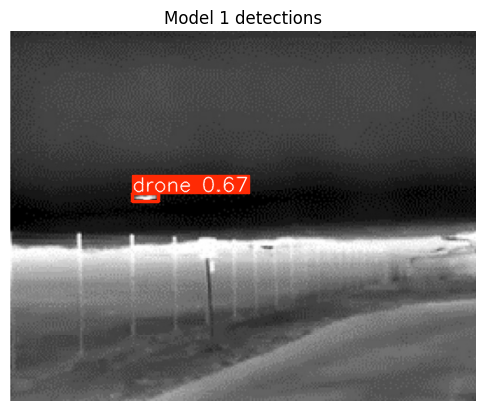


image 1/1 C:\Users\HP\OneDrive\Pictures\Screenshots\Screenshot 2025-08-30 094708.png: 512x640 (no detections), 18.6ms
Speed: 4.6ms preprocess, 18.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


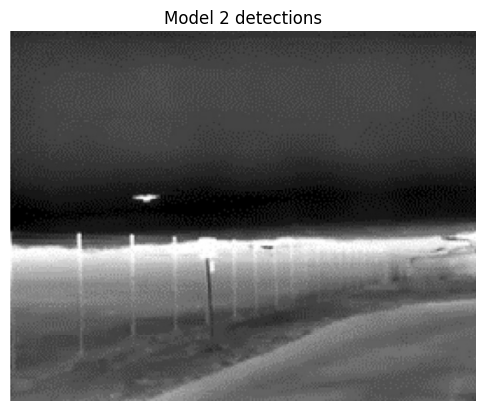


image 1/1 C:\Users\HP\OneDrive\Pictures\Screenshots\Screenshot 2025-08-30 094708.png: 512x640 1 drone, 28.5ms
Speed: 4.0ms preprocess, 28.5ms inference, 4.1ms postprocess per image at shape (1, 3, 512, 640)


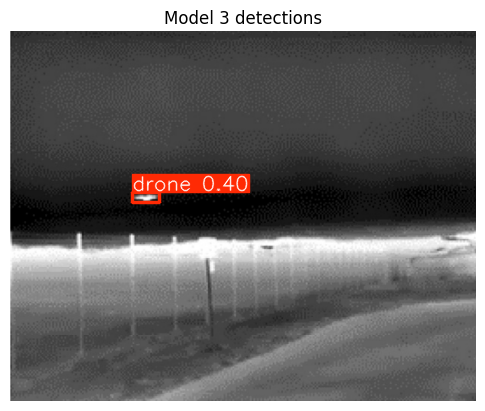


image 1/1 C:\Users\HP\OneDrive\Pictures\Screenshots\Screenshot 2025-08-30 094708.png: 512x640 1 drone, 27.1ms
Speed: 3.4ms preprocess, 27.1ms inference, 4.2ms postprocess per image at shape (1, 3, 512, 640)


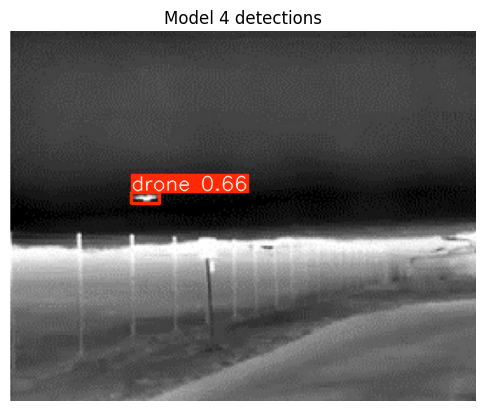

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load all 4 trained models
models = [
    YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sea\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sky\weights\best.pt")
]

# Input image
image_path = r"C:\Users\HP\OneDrive\Pictures\Screenshots\Screenshot 2025-08-30 094708.png"

# Run inference with each model
for i, model in enumerate(models, start=1):
    results = model(image_path)
    results[0].show() 
    plt.imshow(results[0].plot())   # plot with bounding boxes
    plt.title(f"Model {i} detections")
    plt.axis("off")
    plt.show()

In [12]:
# --- evaluate 4 YOLOv8 models and extract IoU-specific mAP values ---
from ultralytics import YOLO
from pathlib import Path

# ===== 1) PATHS (EDIT THESE) =====
DATA = {
    "city":     r"D:\SIDD-main\detectors\city\data.yaml",
    "mountain": r"D:\SIDD-main\detectors\mountain\data.yaml",
    "sea":      r"D:\SIDD-main\detectors\sea\data.yaml",
    "sky":      r"D:\SIDD-main\detectors\sky\data.yaml",
}

WEIGHTS = {
    "city":     r"C:\Users\HP\runs\detect\train-city\weights\best.pt",
    "mountain": r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt",
    "sea":      r"C:\Users\HP\runs\detect\train-sea\weights\best.pt",
    "sky":      r"C:\Users\HP\runs\detect\train-sky\weights\best.pt",
}

# quick sanity check
for k in DATA:
    assert Path(DATA[k]).exists(), f"Missing data.yaml for {k}: {DATA[k]}"
    assert Path(WEIGHTS[k]).exists(), f"Missing weights for {k}: {WEIGHTS[k]}"

# ===== 2) EVALUATE ALL MODELS =====
metrics = {}
for env in ["city", "mountain", "sea", "sky"]:
    print(f"\n==== Evaluating {env} ====")
    try:
        model = YOLO(WEIGHTS[env])
        results = model.val(
            data=DATA[env],
            imgsz=640,
            conf=0.25,
            workers=0,
            batch=4,
            device=0,
            verbose=False,
            save=False
        )

        # Standard metrics
        P   = float(results.box.p)
        R   = float(results.box.r)
        m50 = float(results.box.map50)   # mAP@0.5
        m95 = float(results.box.map)     # mAP@0.5:0.95

        # Per-IoU metrics (0.5 → 0.95, step 0.05)
        maps = results.box.maps  # should be length 10

        if maps is not None and len(maps) == 10:
            m60 = float(maps[2])   # IoU=0.60
            m70 = float(maps[4])   # IoU=0.70
            m80 = float(maps[6])   # IoU=0.80
            m90 = float(maps[8])   # IoU=0.90
        else:
            m60 = m70 = m80 = m90 = None  # fallback if not available

        metrics[env] = {
            "Precision": P,
            "Recall": R,
            "mAP50": m50,
            "mAP60": m60,
            "mAP70": m70,
            "mAP80": m80,
            "mAP90": m90,
            "mAP50-95": m95
        }

        # print summary
        print(f"{env} | P: {P:.4f}, R: {R:.4f}, "
              f"mAP@0.5: {m50:.4f}, mAP@0.6: {m60}, "
              f"mAP@0.7: {m70}, mAP@0.8: {m80}, mAP@0.9: {m90}, "
              f"mAP@0.5:0.95: {m95:.4f}")

    except Exception as e:
        print(f"[{env}] validation failed: {e}")


==== Evaluating city ====
Ultralytics 8.3.188  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 293.3158.2 MB/s, size: 20.0 KB)
val: Scanning D:\SIDD-main\detectors\city\labels\val.cache... 219 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 219/219  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 55/55 12.0it/s 4.6s
                   all        219        219      0.986      0.945      0.977      0.742
Speed: 0.5ms preprocess, 5.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\val32
city | P: 0.9863, R: 0.9452, mAP@0.5: 0.9772, mAP@0.6: None, mAP@0.7: None, mAP@0.8: None, mAP@0.9: None, mAP@0.5:0.95: 0.7415

==== Evaluating mountain ====
Ultralytics 8.3.188  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3

In [13]:
# # --- evaluate 4 YOLOv8 models and extract IoU-specific mAP values ---
# from ultralytics import YOLO
# from pathlib import Path

# # ===== 1) PATHS (EDIT THESE) =====
# DATA = {
#     "city":     r"D:\SIDD-main\detectors\city\data.yaml",
#     "mountain": r"D:\SIDD-main\detectors\mountain\data.yaml",
#     "sea":      r"D:\SIDD-main\detectors\sea\data.yaml",
#     "sky":      r"D:\SIDD-main\detectors\sky\data.yaml",
# }

# WEIGHTS = {
#     "city":     r"C:\Users\HP\runs\detect\train-city\weights\best.pt",
#     "mountain": r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt",
#     "sea":      r"C:\Users\HP\runs\detect\train-sea\weights\best.pt",
#     "sky":      r"C:\Users\HP\runs\detect\train-sky\weights\best.pt",
# }

# # quick sanity check
# for k in DATA:
#     assert Path(DATA[k]).exists(), f"Missing data.yaml for {k}: {DATA[k]}"
#     assert Path(WEIGHTS[k]).exists(), f"Missing weights for {k}: {WEIGHTS[k]}"

# # ===== 2) EVALUATE ALL MODELS =====
# metrics = {}
# for env in ["city", "mountain", "sea", "sky"]:
#     print(f"\n==== Evaluating {env} ====")
#     try:
#         model = YOLO(WEIGHTS[env])
#         results = model.val(
#             data=DATA[env],
#             imgsz=640,
#             conf=0.25,
#             workers=0,
#             batch=4,
#             device=0,
#             verbose=False,
#             save=False
#         )

#         # Standard metrics
#         P   = float(results.box.p)
#         R   = float(results.box.r)
#         m50 = float(results.box.map50)   # mAP@0.5
#         m95 = float(results.box.map)     # mAP@0.5:0.95

#         # IoU-specific mAP values (using maps_iou)
#         m60 = float(results.box.maps_iou[1]) if results.box.maps_iou is not None else None
#         m70 = float(results.box.maps_iou[2]) if results.box.maps_iou is not None else None
#         m80 = float(results.box.maps_iou[3]) if results.box.maps_iou is not None else None
#         m90 = float(results.box.maps_iou[4]) if results.box.maps_iou is not None else None

#         metrics[env] = {
#             "Precision": P,
#             "Recall": R,
#             "mAP50": m50,
#             "mAP60": m60,
#             "mAP70": m70,
#             "mAP80": m80,
#             "mAP90": m90,
#             "mAP50-95": m95
#         }

#         # print summary
#         print(f"{env} | P: {P:.4f}, R: {R:.4f}, "
#               f"mAP@0.5: {m50:.4f}, mAP@0.6: {m60}, "
#               f"mAP@0.7: {m70}, mAP@0.8: {m80}, mAP@0.9: {m90}, "
#               f"mAP@0.5:0.95: {m95:.4f}")

#     except Exception as e:
#         print(f"[{env}] validation failed: {e}")


==== Evaluating city ====
Ultralytics 8.3.188  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 291.3120.7 MB/s, size: 27.7 KB)
val: Scanning D:\SIDD-main\detectors\city\labels\val.cache... 219 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 219/219 109953.6it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 55/55 11.6it/s 4.7s
                   all        219        219      0.986      0.945      0.977      0.742
Speed: 0.5ms preprocess, 6.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs\detect\val36
[city] validation failed: 'Metric' object has no attribute 'maps_iou'. See valid attributes below.

    Class for computing evaluation metrics for Ultralytics YOLO models.

    Attributes:
        p (list): Precision for each cl

In [ ]:
from ultralytics import YOLO
import cv2
import json
from pathlib import Path

configs = {
    "city": {
        "model": r"C:\Users\HP\runs\detect\train-city\weights\best.pt",
        "json": r"D:\SIDD-main\SIDD-main\city\coco格式\cococity\annotations\instances_val2017.json"
    },
    "mountain": {
        "model": r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt",
        "json": r"D:\SIDD-main\SIDD-main\moutain\coco格式\moutain2coco\annotations\instances_val2017.json"
    },
    "sea": {
        "model": r"C:\Users\HP\runs\detect\train-sea\weights\best.pt",
        "json": r"D:\SIDD-main\SIDD-main\sea\coco格式\sea2coco\annotations\instances_val2017.json"
    },
    "sky": {
        "model": r"C:\Users\HP\runs\detect\train-sky\weights\best.pt",
        "json": r"D:\SIDD-main\SIDD-main\sky\coco格式\sky2coco\annotations\instances_val2017.json"
    }
}

# Test image path (you can change this)
test_image_path = r"D:\SIDD-main\SIDD-main\city\coco格式\cococity\val2017\647.jpg"

def load_gt_boxes(annotation_files, image_path):
    """Search through multiple annotation JSONs to find GT boxes for the image."""
    filename = Path(image_path).name
    for ann_file in annotation_files:
        with open(ann_file, "r") as f:
            coco_data = json.load(f)

        # Find image_id
        image_id = None
        for img in coco_data["images"]:
            if Path(img["file_name"]).name == filename:
                image_id = img["id"]
                break

        if image_id is None:
            continue  # not found in this JSON, try next one

        # Collect GT boxes
        gt_boxes = []
        for ann in coco_data["annotations"]:
            if ann["image_id"] == image_id:
                x, y, w, h = ann["bbox"]
                gt_boxes.append([int(x), int(y), int(x + w), int(y + h)])
        return gt_boxes  # return once found
    return []


def compute_iou(box1, box2):
    """Compute IoU between two boxes: [x1,y1,x2,y2]."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0
    return inter_area / union_area

all_jsons = [cfg["json"] for cfg in configs.values()]
gt_boxes = load_gt_boxes(all_jsons, test_image_path)

if not gt_boxes:
    print("No ground truth found for this image in any JSON file!")
    exit()

# Load image
image = cv2.imread(test_image_path)

best_iou = -1
best_model_name = None
best_pred_boxes = []

# Loop through all models
for name, cfg in configs.items():
    model = YOLO(cfg["model"])
    results = model.predict(source=test_image_path, imgsz=640, verbose=False)

    pred_boxes = []
    for box in results[0].boxes.xyxy:  # xyxy format
        x1, y1, x2, y2 = [int(coord) for coord in box]
        pred_boxes.append([x1, y1, x2, y2])

    # Compute IoUs
    for pred in pred_boxes:
        for gt in gt_boxes:
            iou = compute_iou(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_model_name = name
                best_pred_boxes = pred_boxes

for box in gt_boxes:
    x1, y1, x2, y2 = box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red for GT
    
# Draw best prediction and GT
for box in best_pred_boxes:
    x1, y1, x2, y2 = box
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for predictions
    cv2.putText(image, f"IoU: {best_iou:.2f}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

print(f"IoU = {best_iou:.2f}")

# Show image
cv2.imshow("Best Prediction vs Ground Truth", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

IoU = 0.97


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:09<00:00, 23.96it/s]


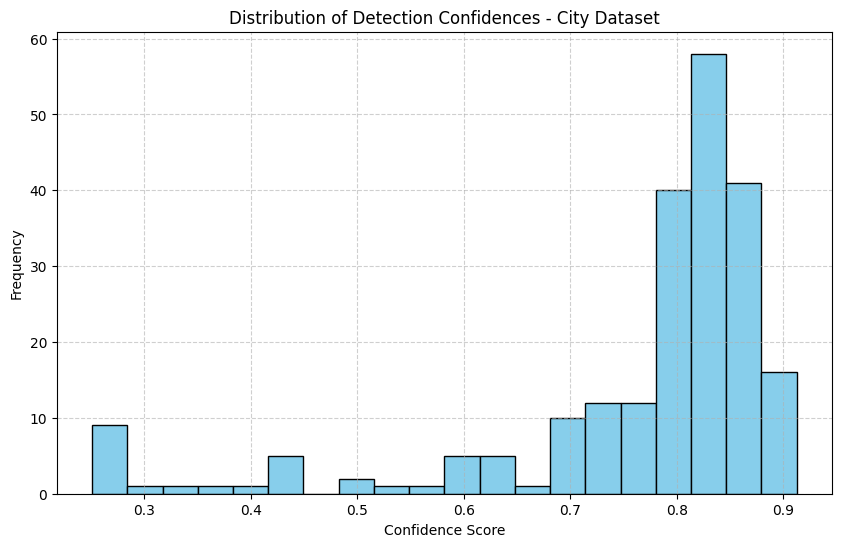

In [11]:
# import os
# import cv2
# import matplotlib.pyplot as plt
# from ultralytics import YOLO
# from tqdm import tqdm

# # ---- SETTINGS ----
# env = "city"   # change to "forest", "rural", "mountain"
# data_dir = r"D:\SIDD-main\SIDD-main\city\coco格式\cococity\val2017"   # your dataset path for this environment
# model_path = r"C:\Users\HP\runs\detect\train-city\weights\best.pt"  # trained model path for this environment

# # Load model
# model = YOLO(model_path)

# # Store confidences
# confidences = []

# # Loop through dataset
# for img_name in tqdm(os.listdir(data_dir)):
#     img_path = os.path.join(data_dir, img_name)
#     img = cv2.imread(img_path)
#     if img is None:
#         continue
    
#     # Run detection
#     results = model(img, verbose=False)
    
#     for r in results:
#         for box in r.boxes:
#             conf = float(box.conf[0].cpu().numpy())
#             confidences.append(conf)

# # ---- PLOTTING ----
# plt.figure(figsize=(10,6))
# plt.hist(confidences, bins=20, color="skyblue", edgecolor="black")
# plt.xlabel("Confidence Score")
# plt.ylabel("Frequency")
# plt.title(f"Distribution of Detection Confidences - {env.capitalize()} Dataset")
# plt.grid(True, linestyle="--", alpha=0.6)
# plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.67it/s]


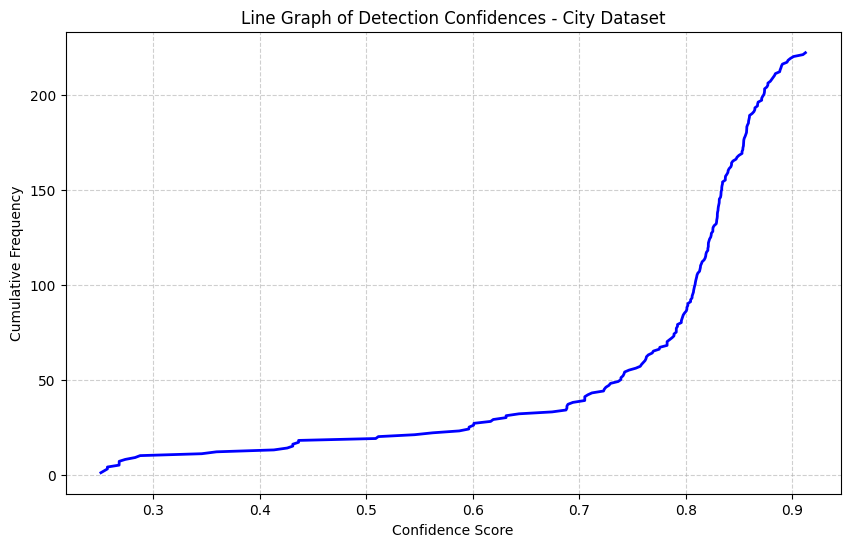

In [10]:
# import os
# import cv2
# import matplotlib.pyplot as plt
# from ultralytics import YOLO
# from tqdm import tqdm

# # ---- SETTINGS ----
# env = "city"   # change to "forest", "rural", "mountain"
# data_dir = r"D:\SIDD-main\SIDD-main\city\coco格式\cococity\val2017"   # your dataset path for this environment
# model_path = r"C:\Users\HP\runs\detect\train-city\weights\best.pt"  # trained model path for this environment

# # Load model
# model = YOLO(model_path)

# # Store confidences
# confidences = []

# # Loop through dataset
# for img_name in tqdm(os.listdir(data_dir)):
#     img_path = os.path.join(data_dir, img_name)
#     img = cv2.imread(img_path)
#     if img is None:
#         continue
    
#     # Run detection
#     results = model(img, verbose=False)
    
#     for r in results:
#         for box in r.boxes:
#             conf = float(box.conf[0].cpu().numpy())
#             confidences.append(conf)

# # ---- PLOTTING ----
# plt.figure(figsize=(10,6))

# # Line graph instead of histogram
# plt.plot(sorted(confidences), range(1, len(confidences)+1), color="blue", linewidth=2)

# plt.xlabel("Confidence Score")
# plt.ylabel("Cumulative Frequency")
# plt.title(f"Line Graph of Detection Confidences - {env.capitalize()} Dataset")
# plt.grid(True, linestyle="--", alpha=0.6)
# plt.show()

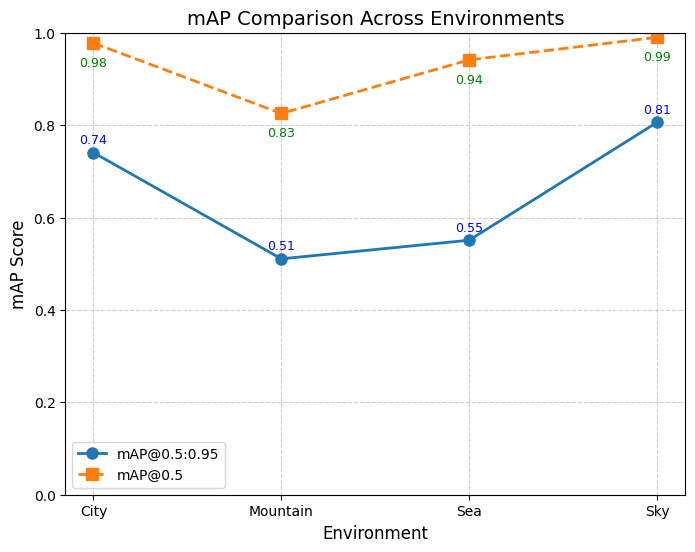

In [5]:
import matplotlib.pyplot as plt

# Example evaluation metrics (replace with your actual results)
map_05_095 = {
    "City": 0.7406,
    "Mountain": 0.5106,
    "Sea": 0.5509,
    "Sky": 0.8061
}

map_05 = {
    "City": 0.9777,
    "Mountain": 0.8252,
    "Sea": 0.9412,
    "Sky": 0.9901
}

# Plot line graph with two lines
plt.figure(figsize=(8,6))

# Plot mAP@0.5:0.95
plt.plot(list(map_05_095.keys()), list(map_05_095.values()), 
         marker='o', linestyle='-', linewidth=2, markersize=8, 
         label="mAP@0.5:0.95")

# Plot mAP@0.5
plt.plot(list(map_05.keys()), list(map_05.values()), 
         marker='s', linestyle='--', linewidth=2, markersize=8, 
         label="mAP@0.5")

plt.title("mAP Comparison Across Environments", fontsize=14)
plt.xlabel("Environment", fontsize=12)
plt.ylabel("mAP Score", fontsize=12)
plt.ylim(0,1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# Annotate values for both lines
for env, val in map_05_095.items():
    plt.text(env, val+0.02, f"{val:.2f}", ha="center", fontsize=9, color="blue")
for env, val in map_05.items():
    plt.text(env, val-0.05, f"{val:.2f}", ha="center", fontsize=9, color="green")

plt.show()

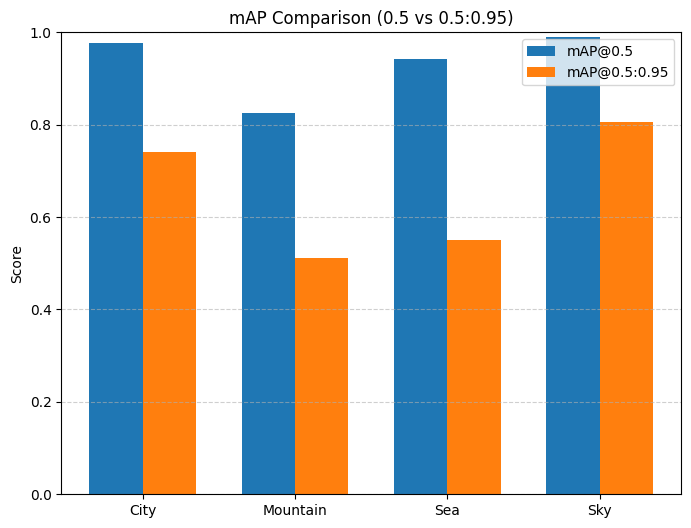

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Example values (replace with your actual evaluation results)
map_05 = {
    "City": 0.9777,
    "Mountain": 0.8252,
    "Sea": 0.9412,
    "Sky": 0.9901
}

map_05_95 = {
    "City": 0.7406,
    "Mountain": 0.5106,
    "Sea": 0.5509,
    "Sky": 0.8061
}

environments = list(map_05.keys())
x = np.arange(len(environments))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, map_05.values(), width, label="mAP@0.5")
plt.bar(x + width/2, map_05_95.values(), width, label="mAP@0.5:0.95")

plt.xticks(x, environments)
plt.ylabel("Score")
plt.title("mAP Comparison (0.5 vs 0.5:0.95)")
plt.ylim(0,1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

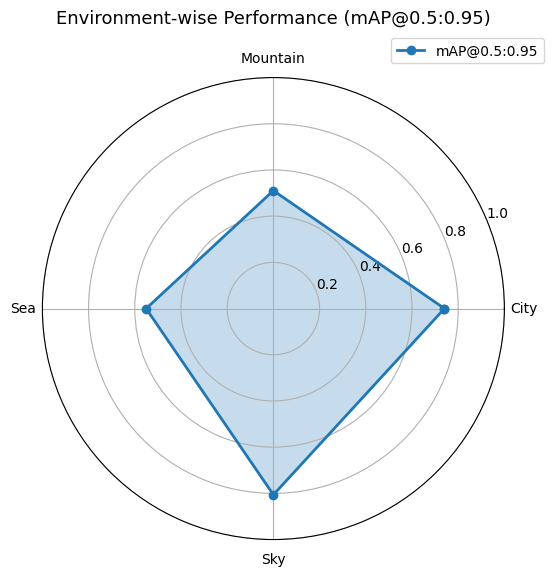

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Example values (replace with real ones)
map_05_95 = {
    "City": 0.7406,
    "Mountain": 0.5106,
    "Sea": 0.5509,
    "Sky": 0.8061
}

labels = list(map_05_95.keys())
stats = list(map_05_95.values())

# Radar chart setup
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
stats += stats[:1]
angles += angles[:1]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

ax.plot(angles, stats, 'o-', linewidth=2, label="mAP@0.5:0.95")
ax.fill(angles, stats, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax.set_ylim(0,1)

plt.title("Environment-wise Performance (mAP@0.5:0.95)", fontsize=13, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.1,1.1))
plt.show()

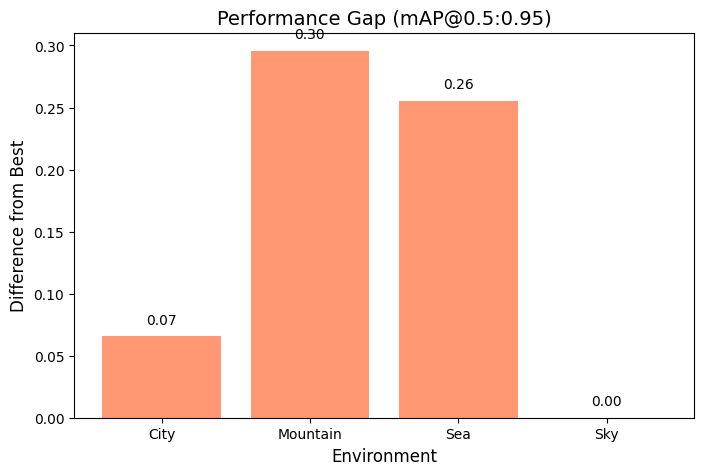

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# mAP@0.5:0.95 values for each environment (example values, replace with yours)
environments = ["City", "Mountain", "Sea", "Sky"]
map_scores = [0.7406, 0.5106, 0.5509, 0.8061] 

# Find best-performing environment
max_score = max(map_scores)

# Calculate difference from the best
differences = [max_score - score for score in map_scores]

# Plot difference
plt.figure(figsize=(8,5))
bars = plt.bar(environments, differences, color="coral", alpha=0.8)

# Highlight the best performer (zero difference)
for i, diff in enumerate(differences):
    plt.text(i, diff + 0.01, f"{diff:.2f}", ha="center", fontsize=10)

plt.title("Performance Gap (mAP@0.5:0.95)", fontsize=14)
plt.ylabel("Difference from Best", fontsize=12)
plt.xlabel("Environment", fontsize=12)
plt.show()

In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [1]:
import torch, torchvision
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))
    x = torch.rand(2,3).to("cuda")
    print("tensor device:", x.device)

torch: 2.5.1+cu121
cuda available: True
device: NVIDIA GeForce RTX 3050 Laptop GPU
tensor device: cuda:0


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [9]:
import sys
print(sys.executable)

D:\conda_envs\drone-gpu\python.exe


In [5]:
print("v")

v


In [ ]:
from ultralytics import YOLO
from pathlib import Path
import torch, gc

def train_detector(env, epochs=10, imgsz=640, batch=8):
    env_path = DET / Path(env)
    data_yaml = env_path / "data.yaml"
    
    data_yaml.write_text(f"""# {env} drone detector
path: {env_path.as_posix()}
train: images/train
val: images/val
names:
  0: drone
""")
    
    model = YOLO("yolov8n.pt")
    results = model.train(
        data=str(data_yaml),
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=20,
        device=0
    )

    del model
    gc.collect()
    torch.cuda.empty_cache()

    return results

for env in ["city","mountain","sea","sky"]:
    train_detector(env, epochs=10, imgsz=640, batch=8)

## From here we are starting Trajectory tracking
## Group 7th Semester Project

In [2]:
import os
import cv2
import json

# === PATHS ===
DATASET_ROOT = r"D:\Anti-UAV-RGBT"
TRAIN_PATH = os.path.join(DATASET_ROOT, "train")

# === Function to load video and JSON ===
def load_video_and_annotations(video_folder):
    """
    Given a folder (like Train/0001), this loads:
      - Visible video
      - Visible JSON annotations
    Returns: list of frames, list of gt_boxes
    """
    video_path = os.path.join(video_folder, "visible.mp4")
    json_path = os.path.join(video_folder, "visible.json")

    # Load JSON ground truth
    with open(json_path, "r") as f:
        annotations = json.load(f)

    gt_rects = annotations["gt_rect"]
    exists = annotations["exist"]

    # Read video frames
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    # Make sure GT and frames match length
    gt_rects = gt_rects[:len(frames)]
    exists = exists[:len(frames)]

    print(f"Loaded {len(frames)} frames from {video_folder}")
    return frames, gt_rects, exists


# === Example use ===
if __name__ == "__main__":
    # Example: Pick one subfolder from Train
    example_folder = os.path.join(TRAIN_PATH, os.listdir(TRAIN_PATH)[0])
    frames, gt_rects, exists = load_video_and_annotations(example_folder)

    print(f"Sample frame shape: {frames[0].shape}")
    print(f"Sample GT box: {gt_rects[0]}")

KeyboardInterrupt: 

In [13]:
!D:\conda_envs\drone-gpu\python.exe -m pip install deep-sort-realtime

  Using cached deep_sort_realtime-1.3.2-py3-none-any.whl.metadata (12 kB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached deep_sort_realtime-1.3.2-py3-none-any.whl (8.4 MB)
Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)

   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]



ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\conda_envs\\drone-gpu\\Lib\\site-packages\\numpy\\linalg\\_umath_linalg.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from deep_sort_realtime.deepsort_tracker import DeepSort
import os

models = [
    YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sea\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sky\weights\best.pt")
]

visible_video_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_1\visible.mp4"
infrared_video_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_1\infrared.mp4"

def select_best_model(models, frame):
    iou_scores = []
    detections = []

    for model in models:
        result = model(frame)
        boxes = result[0].boxes.xyxy.cpu().numpy()
        detections.append(boxes)
        iou_scores.append(len(boxes))

    best_model_idx = np.argmax(iou_scores)
    best_boxes = detections[best_model_idx]
    return best_model_idx, best_boxes

tracker = DeepSort(max_age=10, n_init=2, nms_max_overlap=1.0)

cap_vis = cv2.VideoCapture(visible_video_path)
cap_ir = cv2.VideoCapture(infrared_video_path)

if not cap_vis.isOpened() or not cap_ir.isOpened():
    print("Error: Could not open one or both videos.")
    exit()

frame_idx = 0
trajectory_data = {}

while True:
    ret_vis, frame_vis = cap_vis.read()
    ret_ir, frame_ir = cap_ir.read()
    if not ret_vis or not ret_ir:
        break
    frame_idx += 1
    frame_vis = cv2.resize(frame_vis, (640, 480))
    frame_ir = cv2.resize(frame_ir, (640, 480))
    combined_frame = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)
    best_model_idx, boxes = select_best_model(models, combined_frame)
    print(f"Frame {frame_idx}: Using model {best_model_idx + 1}")
    detections_for_tracker = []
    for box in boxes:
        x1, y1, x2, y2 = box
        detections_for_tracker.append(([x1, y1, x2 - x1, y2 - y1], 0.9, 'drone'))

    tracks = tracker.update_tracks(detections_for_tracker, frame=combined_frame) 
    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        if track_id not in trajectory_data:
            trajectory_data[track_id] = []
        trajectory_data[track_id].append((cx, cy))
        cv2.rectangle(combined_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        for j in range(1, len(trajectory_data[track_id])):
            cv2.line(
                combined_frame,
                trajectory_data[track_id][j - 1],
                trajectory_data[track_id][j],
                (0, 0, 255), 2
            )
        cv2.putText(combined_frame, f"Drone {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    cv2.imshow("Visible + Infrared Drone Tracking", combined_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap_vis.release()
cap_ir.release()
cv2.destroyAllWindows()

print("Trajectory tracking completed successfully!")

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\deep_sort_realtime\embedder\embedder_pytorch.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_


0: 480x640 1 drone, 67.6ms
Speed: 5.5ms preprocess, 67.6ms inference, 177.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 11.7ms
Speed: 2.6ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 9.7ms
Speed: 1.0ms preprocess, 9.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 9.6ms
Speed: 0.9ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Frame 1: Using model 1

0: 480x640 1 drone, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 9.0ms
Speed: 1.6ms preprocess, 9.0ms in

In [9]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# ------------------------------------------------------------
# Load all 4 trained detection models
# ------------------------------------------------------------
models = [
    YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sea\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sky\weights\best.pt")
]

# ------------------------------------------------------------
# Input visible and infrared video paths (pair)
# ------------------------------------------------------------
visible_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\infrared.mp4"
infrared_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\visible.mp4"

# ------------------------------------------------------------
# Initialize video captures
# ------------------------------------------------------------
cap_vis = cv2.VideoCapture(visible_path)
cap_ir  = cv2.VideoCapture(infrared_path)

# ------------------------------------------------------------
# DeepSORT tracker initialization
# ------------------------------------------------------------
tracker = DeepSort(max_age=30, n_init=3, nn_budget=100)

# ------------------------------------------------------------
# Step 1: Determine best model for this video using first 10 frames
# ------------------------------------------------------------
print("[INFO] Selecting best detection model for this video...")

frame_count = 0
scores = np.zeros(len(models))

while frame_count < 10:
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)

    # Evaluate all models on this frame
    for i, model in enumerate(models):
        results = model.predict(combined, verbose=False)
        confs = [box.conf[0].item() for box in results[0].boxes] if results[0].boxes else []
        if confs:
            scores[i] += np.mean(confs)

    frame_count += 1

best_model_idx = int(np.argmax(scores))
best_model = models[best_model_idx]
print(f"[INFO] Selected Model {best_model_idx + 1} as best for this video.")

# ------------------------------------------------------------
# Step 2: Tracking phase using only the best model
# ------------------------------------------------------------
cap_vis.set(cv2.CAP_PROP_POS_FRAMES, 0)
cap_ir.set(cv2.CAP_PROP_POS_FRAMES, 0)

frame_id = 0
print("[INFO] Starting trajectory tracking... Press 'q' to exit.")

while cap_vis.isOpened() and cap_ir.isOpened():
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    # Skip frames (sample every 10th frame)
    # if frame_id % 3 != 0:
    #     frame_id += 1
    #     continue

    # Resize frames
    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)

    # YOLO detection (only the best model)
    results = best_model.predict(combined, verbose=False)
    detections = []
    if results[0].boxes:
        for box in results[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = float(box.conf[0])
            detections.append(([x1, y1, x2 - x1, y2 - y1], conf, 'drone'))

    # DeepSORT tracking
    tracks = tracker.update_tracks(detections, frame=combined)

    # Draw bounding boxes + trajectories
    for track in tracks:
        if not track.is_confirmed():
            continue
        x, y, w, h = track.to_ltrb()
        track_id = track.track_id
        center = (int((x + w) / 2), int((y + h) / 2))
        cv2.rectangle(combined, (int(x), int(y)), (int(w), int(h)), (0, 255, 0), 2)
        cv2.putText(combined, f"Drone ID {track_id}", (int(x), int(y) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        if hasattr(track, "trajectory"):
            track.trajectory.append(center)
        else:
            track.trajectory = [center]

        # draw trajectory line
        for i in range(1, len(track.trajectory)):
            cv2.line(combined, track.trajectory[i - 1], track.trajectory[i], (0, 255, 255), 2)

    # Show the output live
    cv2.imshow("Drone Tracking", combined)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_id += 1

cap_vis.release()
cap_ir.release()
cv2.destroyAllWindows()

print("[INFO] Tracking completed.")

[INFO] Selecting best detection model for this video...
[INFO] Selected Model 4 as best for this video.
[INFO] Starting trajectory tracking... Press 'q' to exit.
[INFO] Tracking completed.


In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# ------------------------------------------------------------
# Load all 4 trained detection models
# ------------------------------------------------------------
models = [
    YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sea\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sky\weights\best.pt")
]

# ------------------------------------------------------------
# Input visible and infrared video paths (pair)
# ------------------------------------------------------------
visible_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\infrared.mp4"
infrared_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\visible.mp4"

# ------------------------------------------------------------
# Initialize video captures
# ------------------------------------------------------------
cap_vis = cv2.VideoCapture(visible_path)
cap_ir = cv2.VideoCapture(infrared_path)

# ------------------------------------------------------------
# Initialize DeepSORT tracker (tuned params)
# ------------------------------------------------------------
tracker = DeepSort(
    max_age=25,         # track is kept for 25 frames after missing
    n_init=3,           # number of frames needed to confirm a track
    nn_budget=100,      # limits tracker memory
    max_cosine_distance=0.4  # lower = stricter matching
)

# ------------------------------------------------------------
# Step 1: Determine best detection model for this video (first 10 frames)
# ------------------------------------------------------------
print("[INFO] Selecting best detection model for this video...")

frame_count = 0
scores = np.zeros(len(models))

while frame_count < 10:
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    # resize both frames
    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))

    # combine both (Visible + IR)
    combined = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)

    # evaluate each model for mean confidence
    for i, model in enumerate(models):
        results = model.predict(combined, conf=0.6, iou=0.45, verbose=False)
        confs = results[0].boxes.conf.cpu().numpy() if results[0].boxes else []
        if len(confs) > 0:
            scores[i] += np.mean(confs)

    frame_count += 1

best_model_idx = int(np.argmax(scores))
best_model = models[best_model_idx]
print(f"[INFO] Selected Model {best_model_idx + 1} as best for this video.")

# ------------------------------------------------------------
# Step 2: Tracking phase using only the best model
# ------------------------------------------------------------
cap_vis.set(cv2.CAP_PROP_POS_FRAMES, 0)
cap_ir.set(cv2.CAP_PROP_POS_FRAMES, 0)

frame_id = 0
print("[INFO] Starting trajectory tracking... Press 'q' to exit.")

while cap_vis.isOpened() and cap_ir.isOpened():
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)

    # Run detection only with best model (with thresholds)
    results = best_model.predict(combined, conf=0.6, iou=0.45, verbose=False)

    detections = []
    if len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()

        # keep only one best detection (highest confidence)
        best_idx = np.argmax(confs)
        x1, y1, x2, y2 = boxes[best_idx]
        conf = float(confs[best_idx])
        detections = [([x1, y1, x2 - x1, y2 - y1], conf, 'drone')]

    # update tracker
    tracks = tracker.update_tracks(detections, frame=combined)

    # draw boxes and trajectory
    for track in tracks:
        if not track.is_confirmed():
            continue
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        track_id = track.track_id
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        cv2.rectangle(combined, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(combined, f"Drone ID {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        # store trajectory
        if not hasattr(track, "trajectory"):
            track.trajectory = []
        track.trajectory.append(center)
        for i in range(1, len(track.trajectory)):
            cv2.line(combined, track.trajectory[i - 1], track.trajectory[i], (0, 255, 255), 2)

    cv2.imshow("Drone Tracking", combined)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_id += 1

cap_vis.release()
cap_ir.release()
cv2.destroyAllWindows()
print("[INFO] Tracking completed.")

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\deep_sort_realtime\embedder\embedder_pytorch.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_

KeyboardInterrupt: 

In [5]:
## Better than others till now.

import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# ------------------------------------------------------------
# Load all 4 trained detection models
# ------------------------------------------------------------
models = [
    YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sea\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sky\weights\best.pt")
]

# ------------------------------------------------------------
# Input visible and infrared video paths (pair)
# ------------------------------------------------------------
visible_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\visible.mp4"
infrared_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\infrared.mp4"

# ------------------------------------------------------------
# Initialize video captures
# ------------------------------------------------------------
cap_vis = cv2.VideoCapture(visible_path)
cap_ir = cv2.VideoCapture(infrared_path)

# ------------------------------------------------------------
# Initialize DeepSORT tracker (tuned params)
# ------------------------------------------------------------
tracker = DeepSort(
    max_age=25,
    n_init=3,
    nn_budget=100,
    max_cosine_distance=0.4
)

# ------------------------------------------------------------
# Step 1: Determine best detection model for this video (first 10 frames)
# ------------------------------------------------------------
print("[INFO] Selecting best detection model for this video...")

frame_count = 0
scores = np.zeros(len(models))

while frame_count < 10:
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)

    for i, model in enumerate(models):
        results = model.predict(combined, conf=0.6, iou=0.8, verbose=False)
        confs = results[0].boxes.conf.cpu().numpy() if results[0].boxes else []
        if len(confs) > 0:
            scores[i] += np.mean(confs)

    frame_count += 1

best_model_idx = int(np.argmax(scores))
best_model = models[best_model_idx]
print(f"[INFO] Selected Model {best_model_idx + 1} as best for this video.")

# ------------------------------------------------------------
# Step 2: Tracking phase using only the best model
# ------------------------------------------------------------
cap_vis.set(cv2.CAP_PROP_POS_FRAMES, 0)
cap_ir.set(cv2.CAP_PROP_POS_FRAMES, 0)

frame_id = 0
print("[INFO] Starting trajectory tracking... Press 'q' to exit.")

while cap_vis.isOpened() and cap_ir.isOpened():
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)

    # Run detection only with best model
    results = best_model.predict(combined, conf=0.6, iou=0.8, verbose=False)

    detections = []
    if len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()

        best_idx = np.argmax(confs)
        x1, y1, x2, y2 = boxes[best_idx]
        conf = float(confs[best_idx])
        detections = [([x1, y1, x2 - x1, y2 - y1], conf, 'drone')]

    # Update tracker
    tracks = tracker.update_tracks(detections, frame=combined)

    # Draw on INFRARED frame only
    for track in tracks:
        if not track.is_confirmed():
            continue
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        track_id = track.track_id
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        cv2.rectangle(frame_ir, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame_ir, f"Drone ID {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        if not hasattr(track, "trajectory"):
            track.trajectory = []
        track.trajectory.append(center)

        for i in range(1, len(track.trajectory)):
            cv2.line(frame_ir, track.trajectory[i - 1], track.trajectory[i], (0, 255, 255), 2)

    # Show only INFRARED frame
    cv2.imshow("Drone Tracking (Infrared Only)", frame_ir)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_id += 1

cap_vis.release()
cap_ir.release()
cv2.destroyAllWindows()
print("[INFO] Tracking completed.")

[INFO] Selecting best detection model for this video...
[INFO] Selected Model 4 as best for this video.
[INFO] Starting trajectory tracking... Press 'q' to exit.
[INFO] Tracking completed.


In [8]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# ------------------------------------------------------------
# Load all 4 trained detection models
# ------------------------------------------------------------
models = [
    YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sea\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sky\weights\best.pt")
]

# ------------------------------------------------------------
# Input visible and infrared video paths (pair)
# ------------------------------------------------------------
visible_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\visible.mp4"
infrared_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\infrared.mp4"

# ------------------------------------------------------------
# Initialize video captures
# ------------------------------------------------------------
cap_vis = cv2.VideoCapture(visible_path)
cap_ir = cv2.VideoCapture(infrared_path)

# ------------------------------------------------------------
# Initialize DeepSORT tracker (tuned for smoother, stable tracking)
# ------------------------------------------------------------
tracker = DeepSort(
    max_age=50,              # Keep track alive longer
    n_init=2,                # Confirm track quickly
    nn_budget=100,
    max_cosine_distance=0.3  # Stricter matching
)

# ------------------------------------------------------------
# Step 1: Determine best detection model for this video (first 10 frames)
# ------------------------------------------------------------
print("[INFO] Selecting best detection model for this video...")

frame_count = 0
scores = np.zeros(len(models))

while frame_count < 10:
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    # Resize for faster processing
    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))

    # Combine both for decision making (not for display)
    combined = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)

    for i, model in enumerate(models):
        results = model.predict(combined, conf=0.3, iou=0.45, verbose=False)
        confs = results[0].boxes.conf.cpu().numpy() if results[0].boxes else []
        if len(confs) > 0:
            scores[i] += np.mean(confs)

    frame_count += 1

best_model_idx = int(np.argmax(scores))
best_model = models[best_model_idx]
print(f"[INFO] Selected Model {best_model_idx + 1} as best for this video.")

# ------------------------------------------------------------
# Step 2: Tracking phase using only the best model (infrared display only)
# ------------------------------------------------------------
cap_vis.set(cv2.CAP_PROP_POS_FRAMES, 0)
cap_ir.set(cv2.CAP_PROP_POS_FRAMES, 0)

frame_id = 0
print("[INFO] Starting trajectory tracking... Press 'q' to exit.")

while cap_vis.isOpened() and cap_ir.isOpened():
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    # Reduce frame rate for faster processing (every 10th frame)
    # if frame_id % 10 != 0:
    #     frame_id += 1
    #     continue

    # Resize both frames
    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))

    # Combine for detection (only used internally)
    combined = cv2.addWeighted(frame_vis, 0.8, frame_ir, 0.9, 0)

    # ------------------------------------------------------------
    # Detection using the best model (1 detection per frame)
    # ------------------------------------------------------------
    results = best_model.predict(combined, conf=0.3, iou=0.45, verbose=False)

    detections = []
    if len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()

        # Keep only the single best detection (highest confidence)
        best_idx = np.argmax(confs)
        x1, y1, x2, y2 = boxes[best_idx]
        conf = float(confs[best_idx])
        detections = [([x1, y1, x2 - x1, y2 - y1], conf, 'drone')]

    # ------------------------------------------------------------
    # Update tracker and draw results on INFRARED frame only
    # ------------------------------------------------------------
    tracks = tracker.update_tracks(detections, frame=combined)

    for track in tracks:
        if not track.is_confirmed():
            continue

        x1, y1, x2, y2 = map(int, track.to_ltrb())
        track_id = track.track_id
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        # Smooth trajectory for stable motion
        if not hasattr(track, "trajectory"):
            track.trajectory = []
        track.trajectory.append(center)

        if len(track.trajectory) > 5:
            recent_points = np.array(track.trajectory[-5:])
            smoothed_center = np.mean(recent_points, axis=0).astype(int)
        else:
            smoothed_center = center

        # Draw single bounding box + trajectory
        cv2.rectangle(frame_ir, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame_ir, f"Drone ID {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        for i in range(1, len(track.trajectory)):
            cv2.line(frame_ir, track.trajectory[i - 1], track.trajectory[i], (0, 255, 255), 2)

    # ------------------------------------------------------------
    # Show only infrared frame (no visible frame display)
    # ------------------------------------------------------------
    cv2.imshow("Drone Tracking (Infrared Only)", frame_ir)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_id += 1

# ------------------------------------------------------------
# Cleanup
# ------------------------------------------------------------
cap_vis.release()
cap_ir.release()
cv2.destroyAllWindows()
print("[INFO] Tracking completed successfully.")

[INFO] Selecting best detection model for this video...
[INFO] Selected Model 4 as best for this video.
[INFO] Starting trajectory tracking... Press 'q' to exit.
[INFO] Tracking completed successfully.


In [9]:
print("frame", frame_id, "raw boxes:", len(results[0].boxes))

frame 1000 raw boxes: 2


In [10]:
res_vis = best_model.predict(frame_vis, conf=0.6, iou=0.45)
res_ir  = best_model.predict(frame_ir, conf=0.6, iou=0.45)

WARNING 'source' is missing. Using 'source=D:\conda_envs\drone-gpu\Lib\site-packages\ultralytics\assets'.
WARNING 'source' is missing. Using 'source=D:\conda_envs\drone-gpu\Lib\site-packages\ultralytics\assets'.


In [11]:
results = best_model.predict(combined, conf=0.55, iou=0.4, verbose=False)

In [13]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# ------------------------------------------------------------
# Load all 4 trained detection models
# ------------------------------------------------------------
models = [
    YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sea\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sky\weights\best.pt")
]

# ------------------------------------------------------------
# Input visible and infrared video paths
# ------------------------------------------------------------
visible_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\visible.mp4"
infrared_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\infrared.mp4"

# ------------------------------------------------------------
# Initialize video captures
# ------------------------------------------------------------
cap_vis = cv2.VideoCapture(visible_path)
cap_ir = cv2.VideoCapture(infrared_path)

# ------------------------------------------------------------
# Initialize DeepSORT tracker (stabilized setup)
# ------------------------------------------------------------
tracker = DeepSort(
    max_age=70,               # Keep tracks alive longer
    n_init=3,                 # Require more consistent detections
    nn_budget=100,            # Feature vector buffer size
    max_cosine_distance=0.3,  # Stricter appearance match
    embedder='mobilenet',     # Faster, stable feature extractor
    half=True                 # Use FP16 precision for speed
)

# ------------------------------------------------------------
# Step 1: Select best detection model (first 10 frames)
# ------------------------------------------------------------
print("[INFO] Selecting best detection model for this video...")

frame_count = 0
scores = np.zeros(len(models))

while frame_count < 10:
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)

    for i, model in enumerate(models):
        results = model.predict(combined, conf=0.4, iou=0.45, verbose=False)
        confs = results[0].boxes.conf.cpu().numpy() if results[0].boxes else []
        if len(confs) > 0:
            scores[i] += np.mean(confs)

    frame_count += 1

best_model_idx = int(np.argmax(scores))
best_model = models[best_model_idx]
print(f"[INFO] Selected Model {best_model_idx + 1} as best for this video.")

# ------------------------------------------------------------
# Step 2: Tracking phase (Infrared display only)
# ------------------------------------------------------------
cap_vis.set(cv2.CAP_PROP_POS_FRAMES, 0)
cap_ir.set(cv2.CAP_PROP_POS_FRAMES, 0)

frame_id = 0
print("[INFO] Starting trajectory tracking... Press 'q' to exit.")

while cap_vis.isOpened() and cap_ir.isOpened():
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.8, frame_ir, 0.9, 0)

    # Detection
    results = best_model.predict(combined, conf=0.5, iou=0.45, verbose=False)
    detections = []

    if len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()

        # Filter out low confidence detections
        for box, conf in zip(boxes, confs):
            if conf > 0.5:
                x1, y1, x2, y2 = box
                detections.append(([x1, y1, x2 - x1, y2 - y1], float(conf), 'drone'))

    # Tracking
    tracks = tracker.update_tracks(detections, frame=combined)

    for track in tracks:
        if not track.is_confirmed():
            continue

        x1, y1, x2, y2 = map(int, track.to_ltrb())
        track_id = track.track_id
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        if not hasattr(track, "trajectory"):
            track.trajectory = []
        track.trajectory.append(center)

        # Smooth last few points
        if len(track.trajectory) > 5:
            pts = np.array(track.trajectory[-5:])
            smoothed_center = np.mean(pts, axis=0).astype(int)
        else:
            smoothed_center = center

        # Draw bounding box + trajectory
        cv2.rectangle(frame_ir, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame_ir, f"Drone ID {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
        for i in range(1, len(track.trajectory)):
            cv2.line(frame_ir, track.trajectory[i - 1], track.trajectory[i], (0, 255, 255), 2)

    # Display only IR frame
    cv2.imshow("Drone Tracking (Infrared Only)", frame_ir)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_id += 1

# ------------------------------------------------------------
# Cleanup
# ------------------------------------------------------------
cap_vis.release()
cap_ir.release()
cv2.destroyAllWindows()
print("[INFO] Tracking completed successfully.")

[INFO] Selecting best detection model for this video...
[INFO] Selected Model 4 as best for this video.
[INFO] Starting trajectory tracking... Press 'q' to exit.
[INFO] Tracking completed successfully.


In [14]:
import os
import cv2
import json
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# ------------------------------------------------------------
# === PATHS ===
# ------------------------------------------------------------
DATASET_ROOT = r"D:\Anti-UAV-RGBT"
TRAIN_PATH = os.path.join(DATASET_ROOT, "train")

# === Function to load video and JSON ===
def load_video_and_annotations(video_folder):
    video_path = os.path.join(video_folder, "visible.mp4")
    json_path = os.path.join(video_folder, "visible.json")

    with open(json_path, "r") as f:
        annotations = json.load(f)

    gt_rects = annotations["gt_rect"]
    exists = annotations["exist"]

    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    gt_rects = gt_rects[:len(frames)]
    exists = exists[:len(frames)]

    print(f"Loaded {len(frames)} frames from {video_folder}")
    return frames, gt_rects, exists

In [15]:
# ------------------------------------------------------------
# === LOAD ALL 4 TRAINED YOLO MODELS ===
# ------------------------------------------------------------
models = [
    YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sea\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sky\weights\best.pt")
]

# ------------------------------------------------------------
# === INPUT VIDEO PATHS ===
# ------------------------------------------------------------
visible_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\visible.mp4"
infrared_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\infrared.mp4"

cap_vis = cv2.VideoCapture(visible_path)
cap_ir = cv2.VideoCapture(infrared_path)

# ------------------------------------------------------------
# === INITIALIZE DEEPSORT TRACKER ===
# ------------------------------------------------------------
tracker = DeepSort(
    max_age=70,
    n_init=3,
    nn_budget=100,
    max_cosine_distance=0.3,
    embedder='mobilenet',
    half=True
)

# ------------------------------------------------------------
# === MODEL SELECTION PHASE (FIRST 10 FRAMES) ===
# ------------------------------------------------------------
print("[INFO] Selecting best detection model for this video...")

frame_count = 0
scores = np.zeros(len(models))

while frame_count < 10:
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)

    for i, model in enumerate(models):
        results = model.predict(combined, conf=0.4, iou=0.45, verbose=False)
        confs = results[0].boxes.conf.cpu().numpy() if results[0].boxes else []
        if len(confs) > 0:
            scores[i] += np.mean(confs)

    frame_count += 1

best_model_idx = int(np.argmax(scores))
best_model = models[best_model_idx]
print(f"[INFO] Selected Model {best_model_idx + 1} as best for this video.")

# ------------------------------------------------------------
# === TRACKING PHASE (INFRARED DISPLAY ONLY) ===
# ------------------------------------------------------------
cap_vis.set(cv2.CAP_PROP_POS_FRAMES, 0)
cap_ir.set(cv2.CAP_PROP_POS_FRAMES, 0)

print("[INFO] Starting trajectory tracking... Press 'q' to exit.")

# Dictionary to store colors per drone ID
id_colors = {}
max_traj_length = 20  # keep last N points only

while cap_vis.isOpened() and cap_ir.isOpened():
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.8, frame_ir, 0.9, 0)

    # --- Detection ---
    results = best_model.predict(combined, conf=0.5, iou=0.45, verbose=False)
    detections = []

    if len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()

        for box, conf in zip(boxes, confs):
            if conf > 0.5:
                x1, y1, x2, y2 = box
                detections.append(([x1, y1, x2 - x1, y2 - y1], float(conf), 'drone'))

    # --- Tracking ---
    tracks = tracker.update_tracks(detections, frame=combined)

    for idx, track in enumerate(tracks):
        if not track.is_confirmed():
            continue

        x1, y1, x2, y2 = map(int, track.to_ltrb())
        track_id = track.track_id
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        # Assign a unique color to each drone ID
        if track_id not in id_colors:
            id_colors[track_id] = tuple(np.random.randint(0, 255, 3).tolist())
        color = id_colors[track_id]

        # Initialize and update trajectory
        if not hasattr(track, "trajectory"):
            track.trajectory = []
        track.trajectory.append(center)

        # Limit trajectory length
        if len(track.trajectory) > max_traj_length:
            track.trajectory.pop(0)

        # Smooth last few trajectory points
        if len(track.trajectory) >= 3:
            pts = np.array(track.trajectory[-3:])
            smoothed_center = np.mean(pts, axis=0).astype(int)
        else:
            smoothed_center = center

        # --- Draw elements ---
        cv2.rectangle(frame_ir, (x1, y1), (x2, y2), color, 2)

        # Offset label to prevent overlap (stagger by index)
        label_y = max(20, y1 - 10 - (idx % 4) * 15)
        cv2.putText(frame_ir, f"Drone ID {track_id}", (x1, label_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Draw trajectory (smooth yellow line)
        for i in range(1, len(track.trajectory)):
            cv2.line(frame_ir, track.trajectory[i - 1], track.trajectory[i], (0, 255, 255), 2)

    # --- Display only IR frame ---
    cv2.imshow("Drone Tracking (Infrared Only)", frame_ir)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# ------------------------------------------------------------
# === CLEANUP ===
# ------------------------------------------------------------
cap_vis.release()
cap_ir.release()
cv2.destroyAllWindows()
print("[INFO] Tracking completed successfully.")

[INFO] Selecting best detection model for this video...
[INFO] Selected Model 4 as best for this video.
[INFO] Starting trajectory tracking... Press 'q' to exit.
[INFO] Tracking completed successfully.


In [16]:
# ------------------------------------------------------------
# === LOAD ALL 4 TRAINED YOLO MODELS ===
# ------------------------------------------------------------
models = [
    YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-mountain\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sea\weights\best.pt"),
    YOLO(r"C:\Users\HP\runs\detect\train-sky\weights\best.pt")
]

# ------------------------------------------------------------
# === INPUT VIDEO PATHS ===
# ------------------------------------------------------------
visible_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\visible.mp4"
infrared_path = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_2\infrared.mp4"

cap_vis = cv2.VideoCapture(visible_path)
cap_ir = cv2.VideoCapture(infrared_path)

# ------------------------------------------------------------
# === INITIALIZE DEEPSORT TRACKER ===
# ------------------------------------------------------------
tracker = DeepSort(
    max_age=100,             # track stays longer even if missed
    n_init=2,                # quicker confirmation
    nn_budget=150,           # bigger memory for matching
    max_cosine_distance=0.4, # relax appearance similarity
    embedder='mobilenet',
    half=True
)

# ------------------------------------------------------------
# === MODEL SELECTION PHASE (FIRST 10 FRAMES) ===
# ------------------------------------------------------------
print("[INFO] Selecting best detection model for this video...")

frame_count = 0
scores = np.zeros(len(models))

while frame_count < 10:
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.6, frame_ir, 0.4, 0)

    for i, model in enumerate(models):
        results = model.predict(combined, conf=0.4, iou=0.45, verbose=False)
        confs = results[0].boxes.conf.cpu().numpy() if results[0].boxes else []
        if len(confs) > 0:
            scores[i] += np.mean(confs)

    frame_count += 1

best_model_idx = int(np.argmax(scores))
best_model = models[best_model_idx]
print(f"[INFO] Selected Model {best_model_idx + 1} as best for this video.")

# ------------------------------------------------------------
# === TRACKING PHASE (INFRARED DISPLAY ONLY) ===
# ------------------------------------------------------------
cap_vis.set(cv2.CAP_PROP_POS_FRAMES, 0)
cap_ir.set(cv2.CAP_PROP_POS_FRAMES, 0)

print("[INFO] Starting trajectory tracking... Press 'q' to exit.")

# Dictionary to store colors per drone ID
id_colors = {}
max_traj_length = 20  # keep last N points only

while cap_vis.isOpened() and cap_ir.isOpened():
    ret1, frame_vis = cap_vis.read()
    ret2, frame_ir = cap_ir.read()
    if not ret1 or not ret2:
        break

    frame_vis = cv2.resize(frame_vis, (640, 360))
    frame_ir = cv2.resize(frame_ir, (640, 360))
    combined = cv2.addWeighted(frame_vis, 0.8, frame_ir, 0.9, 0)

    # --- Detection ---
    results = best_model.predict(combined, conf=0.5, iou=0.45, verbose=False)
    detections = []

    if len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()
    
        # Filter: confidence and box size
        filtered = []
        for box, conf in zip(boxes, confs):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            if conf > 0.6 and w * h > 300:  # remove small/noisy detections
                filtered.append((box, conf))

    # Keep only largest detection (most likely the drone)
    if len(filtered) > 0:
        filtered.sort(key=lambda x: (x[1], (x[0][2]-x[0][0])*(x[0][3]-x[0][1])), reverse=True)
        box, conf = filtered[0]
        x1, y1, x2, y2 = box
        detections.append(([x1, y1, x2 - x1, y2 - y1], float(conf), 'drone'))


    # --- Tracking ---
    tracks = tracker.update_tracks(detections, frame=combined)

    for idx, track in enumerate(tracks):
        if not track.is_confirmed():
            continue

        x1, y1, x2, y2 = map(int, track.to_ltrb())
        track_id = track.track_id
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        # Assign a unique color to each drone ID
        if track_id not in id_colors:
            id_colors[track_id] = tuple(np.random.randint(0, 255, 3).tolist())
        color = id_colors[track_id]

        # Initialize and update trajectory
        if not hasattr(track, "trajectory"):
            track.trajectory = []
        track.trajectory.append(center)

        # Limit trajectory length
        if len(track.trajectory) > max_traj_length:
            track.trajectory.pop(0)

        # Smooth last few trajectory points
        if len(track.trajectory) >= 3:
            pts = np.array(track.trajectory[-3:])
            smoothed_center = np.mean(pts, axis=0).astype(int)
        else:
            smoothed_center = center

        # Keep only first confirmed track (the main drone)
        confirmed_tracks = [t for t in tracks if t.is_confirmed()]
        if len(confirmed_tracks) > 0:
            main_track = confirmed_tracks[0]  # keep only one drone
            tracks = [main_track]


        # --- Draw elements ---
        cv2.rectangle(frame_ir, (x1, y1), (x2, y2), color, 2)

        # Offset label to prevent overlap (stagger by index)
        label_y = max(20, y1 - 10 - (idx % 4) * 15)
        cv2.putText(frame_ir, f"Drone ID {track_id}", (x1, label_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Draw trajectory (smooth yellow line)
        for i in range(1, len(track.trajectory)):
            cv2.line(frame_ir, track.trajectory[i - 1], track.trajectory[i], (0, 255, 255), 2)

    # --- Display only IR frame ---
    cv2.imshow("Drone Tracking (Infrared Only)", frame_ir)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# ------------------------------------------------------------
# === CLEANUP ===
# ------------------------------------------------------------
cap_vis.release()
cap_ir.release()
cv2.destroyAllWindows()
print("[INFO] Tracking completed successfully.")

[INFO] Selecting best detection model for this video...
[INFO] Selected Model 4 as best for this video.
[INFO] Starting trajectory tracking... Press 'q' to exit.
[INFO] Tracking completed successfully.


In [2]:
import os
import cv2
import json
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# ==============================================================
# === PATHS ===
# ==============================================================
DATASET_ROOT = r"D:\Anti-UAV-RGBT"
VIDEO_FOLDER = os.path.join(DATASET_ROOT, "train", "20190925_101846_1_2")

VISIBLE_PATH = os.path.join(VIDEO_FOLDER, "visible.mp4")
INFRARED_PATH = os.path.join(VIDEO_FOLDER, "infrared.mp4")

# ==============================================================
# === LOAD SINGLE YOLOv8 MODEL (Unified model recommended) ===
# ==============================================================
# ⚠️ Choose one model only — ideally retrained on all domains.
model = YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt")

# ==============================================================
# === INITIALIZE DEEPSORT TRACKER (Compatible Embedder) ===
# ==============================================================
tracker = DeepSort(
    max_age=30,                 # shorter track lifetime to avoid ghost IDs
    n_init=3,                   # confirm faster
    nn_budget=50,               # reasonable embedding memory
    max_cosine_distance=0.7,    # relaxed threshold for IR variations
    embedder='mobilenet',       # supported and fast; good default choice
    half=True,                  # speeds up embedding inference
    bgr=True                    # important: OpenCV frames are in BGR format
)

# ==============================================================
# === FUNCTION: LOAD VIDEO FRAMES ===
# ==============================================================
def load_video_frames(video_path, resize_to=(640, 360)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize_to)
        frames.append(frame)
    cap.release()
    print(f"[INFO] Loaded {len(frames)} frames from {video_path}")
    return frames

# ==============================================================
# === CHOOSE ONE SOURCE: Infrared preferred for stability ===
# ==============================================================
frames = load_video_frames(INFRARED_PATH)  # Use only IR video

# ==============================================================
# === SETUP ===
# ==============================================================
id_colors = {}
max_traj_length = 25   # trajectory history length
smooth_window = 3      # trajectory smoothing window

print("[INFO] Starting trajectory tracking... Press 'q' to exit.")

# ==============================================================
# === TRACKING LOOP ===
# ==============================================================
for frame_idx, frame in enumerate(frames):

    # --- Detection ---
    results = model.predict(frame, conf=0.55, iou=0.45, verbose=False)
    detections = []

    if len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()

        filtered = []
        for box, conf in zip(boxes, confs):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            area = w * h
            # Remove tiny or very large boxes
            if conf > 0.6 and 1500 < area < 40000:
                filtered.append((box, conf))

        # Keep only the most confident (largest) detection — single drone assumption
        if len(filtered) > 0:
            filtered.sort(key=lambda x: (x[1], (x[0][2]-x[0][0])*(x[0][3]-x[0][1])), reverse=True)
            box, conf = filtered[0]
            x1, y1, x2, y2 = box
            detections.append(([x1, y1, x2 - x1, y2 - y1], float(conf), 'drone'))

    # --- Tracking ---
    tracks = tracker.update_tracks(detections, frame=frame)

    # --- Draw Results ---
    for idx, track in enumerate(tracks):
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

        # Assign consistent color
        if track_id not in id_colors:
            id_colors[track_id] = tuple(np.random.randint(0, 255, 3).tolist())
        color = id_colors[track_id]

        # Initialize trajectory
        if not hasattr(track, "trajectory"):
            track.trajectory = []
        track.trajectory.append(center)

        # Limit trajectory length
        if len(track.trajectory) > max_traj_length:
            track.trajectory.pop(0)

        # Smooth trajectory (moving average)
        if len(track.trajectory) >= smooth_window:
            pts = np.array(track.trajectory[-smooth_window:])
            smoothed_center = tuple(np.mean(pts, axis=0).astype(int))
        else:
            smoothed_center = center

        # Draw bounding box
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

        # Label
        cv2.putText(frame, f"Drone ID {track_id}", (x1, max(25, y1 - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Draw trajectory
        for i in range(1, len(track.trajectory)):
            cv2.line(frame, track.trajectory[i - 1], track.trajectory[i], (0, 255, 255), 2)

    # Display
    cv2.imshow("Drone Trajectory Tracking (Infrared Only)", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
print("[INFO] Tracking completed successfully.")

[INFO] Loaded 1000 frames from D:\Anti-UAV-RGBT\train\20190925_101846_1_2\infrared.mp4
[INFO] Starting trajectory tracking... Press 'q' to exit.
[INFO] Tracking completed successfully.


In [6]:
!D:\conda_envs\drone-gpu\python.exe -m pip install git+https://github.com/Megvii-BaseDetection/YOLOX.git

  Cloning https://github.com/Megvii-BaseDetection/YOLOX.git to c:\users\hp\appdata\local\temp\pip-req-build-e4bywrrz
  Resolved https://github.com/Megvii-BaseDetection/YOLOX.git to commit 6ddff4824372906469a7fae2dc3206c7aa4bbaee
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached loguru-0.7.3-py3-none-any.whl.metadata (22 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
  Using cached ninja-1.13.0-py3-none-win_amd64.whl.metadata (5.1 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ---------------------------------------- 0

  Running command git clone --filter=blob:none --quiet https://github.com/Megvii-BaseDetection/YOLOX.git 'C:\Users\HP\AppData\Local\Temp\pip-req-build-e4bywrrz'
  on a case-insensitive filesystem) and only one from the same
  colliding group is in the working tree:

    'demo/ncnn/android/app/src/main/java/com/megvii/yoloXncnn/YOLOXncnn.java'
    'demo/ncnn/android/app/src/main/java/com/megvii/yoloXncnn/yoloXncnn.java'
  DEPRECATION: Building 'yolox' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'yolox'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consi

In [9]:
!D:\conda_envs\drone-gpu\python.exe -m pip install git+https://github.com/ifzhang/ByteTrack.git

  Cloning https://github.com/ifzhang/ByteTrack.git to c:\users\hp\appdata\local\temp\pip-req-build-ljxzhy7f
  Resolved https://github.com/ifzhang/ByteTrack.git to commit d1bf0191adff59bc8fcfeaa0b33d3d1642552a99
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for yolox
Failed to build yolox


  Running command git clone --filter=blob:none --quiet https://github.com/ifzhang/ByteTrack.git 'C:\Users\HP\AppData\Local\Temp\pip-req-build-ljxzhy7f'
  DEPRECATION: Building 'yolox' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'yolox'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [197 lines of output]
  running bdist_wheel
  D:\conda_envs\drone-gpu\lib\site-packages\torch\utils\cpp_extension.py:497: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
    warni

In [11]:
# Option B1: YOLOv8 + BYTETracker (requires yolox/bytetrack available)
import os
import cv2
import numpy as np
from ultralytics import YOLO
from byte_tracker import BYTETracker


# Try to import BYTETracker from yolox; adjust if you installed a bytetrack package
try:
    # Many yolox installs use: from yolox.tracker.byte_tracker import BYTETracker
    from yolox.tracker.byte_tracker import BYTETracker
except Exception as e:
    raise ImportError("BYTETracker import failed. Install yolox or ByteTrack. Error: " + str(e))

# === PATHS ===
DATASET_ROOT = r"D:\Anti-UAV-RGBT"
VIDEO_FOLDER = os.path.join(DATASET_ROOT, "train", "20190925_101846_1_2")
INFRARED_PATH = os.path.join(VIDEO_FOLDER, "infrared.mp4")

# === YOLO (single unified model) ===
model = YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt")

# === INIT BYTETracker ===
# The constructor signature may expect an args object in some versions; we'll try a simple wrapper.
# If your BYTETracker requires an args-like object, create a small class with required fields.
class BTArgs:
    def __init__(self):
        self.track_thresh = 0.5   # minimum score for high-quality detection
        self.track_buffer = 30    # how long to keep lost tracks (frames)
        self.match_thresh = 0.8   # IoU threshold for matching
        self.mot20 = False

bt_args = BTArgs()
tracker = BYTETracker(bt_args, frame_rate=30)  # frame_rate as appropriate

# Helper: convert YOLO results to ByteTrack detection format
def yolo_to_dets(results):
    dets = []
    if len(results[0].boxes) == 0:
        return dets
    boxes = results[0].boxes.xyxy.cpu().numpy()
    confs = results[0].boxes.conf.cpu().numpy()
    for box, conf in zip(boxes, confs):
        x1, y1, x2, y2 = box.astype(float)
        dets.append([x1, y1, x2, y2, float(conf)])
    return np.array(dets)  # shape: (N,5)

# === Video capture ===
cap = cv2.VideoCapture(INFRARED_PATH)
id_colors = {}
trajectory = {}   # traj per track_id
max_traj = 150

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_resized = cv2.resize(frame, (640, 360))
    results = model.predict(frame_resized, conf=0.45, iou=0.45, verbose=False)
    dets = yolo_to_dets(results)  # (N,5) or empty

    # BYTETracker expects a list/ndarray of dets: [x1,y1,x2,y2,score]
    online_targets = tracker.update(dets, [frame_resized.shape[0], frame_resized.shape[1]], frame_resized.shape[2])

    # online_targets is a list of Track objects with .tlwh(), .track_id, .tlbr(), etc.
    for t in online_targets:
        tlwh = t.tlwh  # (x, y, w, h)
        track_id = t.track_id
        x1, y1, w, h = tlwh
        x1, y1, x2, y2 = int(x1), int(y1), int(x1 + w), int(y1 + h)
        center = (int((x1 + x2)/2), int((y1 + y2)/2))

        if track_id not in id_colors:
            id_colors[track_id] = tuple(np.random.randint(0,255,3).tolist())
            trajectory[track_id] = []

        trajectory[track_id].append(center)
        if len(trajectory[track_id]) > max_traj:
            trajectory[track_id].pop(0)

        color = id_colors[track_id]
        cv2.rectangle(frame_resized, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame_resized, f"ID {track_id}", (x1, max(20, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # draw traj
        for i in range(1, len(trajectory[track_id])):
            cv2.line(frame_resized, trajectory[track_id][i-1], trajectory[track_id][i], (0,255,255), 2)

    cv2.imshow("BYTETrack - Infrared", frame_resized)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'byte_tracker'

## New Approach on trajectory tracking

In [1]:
import cv2
import os

def extract_frames_from_videos(root_dir, output_dir):
    """
    Extract frames from all .mp4 videos in the dataset recursively.
    """
    os.makedirs(output_dir, exist_ok=True)

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".mp4"):
                video_path = os.path.join(subdir, file)
                cap = cv2.VideoCapture(video_path)
                video_name = os.path.splitext(file)[0]
                save_dir = os.path.join(output_dir, video_name)
                os.makedirs(save_dir, exist_ok=True)

                frame_id = 0
                while True:
                    success, frame = cap.read()
                    if not success:
                        break
                    frame_file = os.path.join(save_dir, f"{frame_id:04d}.jpg")
                    cv2.imwrite(frame_file, frame)
                    frame_id += 1
                cap.release()

                print(f"Extracted {frame_id} frames from {video_name}")

root_videos = r"D:\Anti-UAV-RGBT\new_train"
output_frames = r"D:\Anti-UAV-RGBT\frames\train"
extract_frames_from_videos(root_videos, output_frames)

Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 899 frames from infrared
Extracted 899 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 869 frames from infrared
Extracted 869 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 1000 frames from infrared
Extracted 1000 frames from visible
Extracted 

KeyboardInterrupt: 

In [3]:
import json
import os
from tqdm import tqdm

def convert_json_to_yolo(json_path, frames_dir, labels_output_dir, img_width, img_height):
    """
    Convert Anti-UAV JSON annotations into YOLO txt labels.
    """
    os.makedirs(labels_output_dir, exist_ok=True)

    with open(json_path, "r") as f:
        data = json.load(f)

    exist = data["exist"]
    rects = data["gt_rect"]

    for i, (e, rect) in enumerate(zip(exist, rects)):
        if e == 0:
            continue  # no drone in this frame

        x, y, w, h = rect
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        w_norm = w / img_width
        h_norm = h / img_height

        label_path = os.path.join(labels_output_dir, f"{i:04d}.txt")
        with open(label_path, "w") as f:
            # class_id is 0 (drone)
            f.write(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

    print(f"Labels saved in {labels_output_dir}")

# Example
json_file = r"D:\Anti-UAV-RGBT\train\20190925_101846_1_1\visible.json"
frames_dir = r"D:\Anti-UAV-RGBT\frames\train\infrared"
labels_dir = r"D:\Anti-UAV-RGBT\label_new"
img_width, img_height = 640, 512  # Adjust to your video resolution

convert_json_to_yolo(json_file, frames_dir, labels_dir, img_width, img_height)

Labels saved in D:\Anti-UAV-RGBT\label_new


In [4]:
!D:\conda_envs\drone-gpu\python.exe -m pip install ultralytics

In [1]:
import os
import random
import shutil

# Paths
infra_train = r"D:\Anti-UAV-RGBT\frames\train\infrared"
vis_train = r"D:\Anti-UAV-RGBT\frames\train\visible"
labels_dir = r"D:\Anti-UAV-RGBT\label_new"

infra_val = r"D:\Anti-UAV-RGBT\frames\val\infrared"
vis_val = r"D:\Anti-UAV-RGBT\frames\val\visible"

# Create val folders if not exist
os.makedirs(infra_val, exist_ok=True)
os.makedirs(vis_val, exist_ok=True)

# Get list of files (assuming same filenames for visible, infrared, and label)
infra_images = sorted(os.listdir(infra_train))
random.shuffle(infra_images)

# Use 20% for validation
val_count = int(0.2 * len(infra_images))
val_images = infra_images[:val_count]

# Move files
for i, img_name in enumerate(val_images, 1):
    base = os.path.splitext(img_name)[0]
    label_name = base + ".txt"

    # Define source and destination paths
    src_infra = os.path.join(infra_train, img_name)
    dst_infra = os.path.join(infra_val, img_name)

    src_vis = os.path.join(vis_train, img_name)
    dst_vis = os.path.join(vis_val, img_name)

    src_label = os.path.join(labels_dir, label_name)

    # Move images if exist
    if os.path.exists(src_infra):
        shutil.move(src_infra, dst_infra)
    if os.path.exists(src_vis):
        shutil.move(src_vis, dst_vis)
    if os.path.exists(src_label):
        shutil.move(src_label, os.path.join(labels_dir, "val_" + label_name))  # Optional: rename val labels to avoid confusion

    print(f"[{i}/{val_count}] Moved: {img_name}")

print("\n Split completed! 20% of infrared and visible images moved to val folders.")

[1/200] Moved: 0098.jpg
[2/200] Moved: 0015.jpg
[3/200] Moved: 0664.jpg
[4/200] Moved: 0447.jpg
[5/200] Moved: 0794.jpg
[6/200] Moved: 0686.jpg
[7/200] Moved: 0472.jpg
[8/200] Moved: 0252.jpg
[9/200] Moved: 0825.jpg
[10/200] Moved: 0677.jpg
[11/200] Moved: 0558.jpg
[12/200] Moved: 0368.jpg
[13/200] Moved: 0538.jpg
[14/200] Moved: 0750.jpg
[15/200] Moved: 0028.jpg
[16/200] Moved: 0835.jpg
[17/200] Moved: 0180.jpg
[18/200] Moved: 0211.jpg
[19/200] Moved: 0066.jpg
[20/200] Moved: 0601.jpg
[21/200] Moved: 0639.jpg
[22/200] Moved: 0145.jpg
[23/200] Moved: 0993.jpg
[24/200] Moved: 0266.jpg
[25/200] Moved: 0354.jpg
[26/200] Moved: 0657.jpg
[27/200] Moved: 0280.jpg
[28/200] Moved: 0445.jpg
[29/200] Moved: 0615.jpg
[30/200] Moved: 0651.jpg
[31/200] Moved: 0415.jpg
[32/200] Moved: 0761.jpg
[33/200] Moved: 0913.jpg
[34/200] Moved: 0306.jpg
[35/200] Moved: 0208.jpg
[36/200] Moved: 0328.jpg
[37/200] Moved: 0923.jpg
[38/200] Moved: 0283.jpg
[39/200] Moved: 0561.jpg
[40/200] Moved: 0350.jpg
[41/200] 

In [1]:
from ultralytics import YOLO

# Load your SIDD-trained model
model = YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt")

# Fine-tune on Anti-UAV data
model.train(
    data=r"D:\Anti-UAV-RGBT\data.yml",
    epochs=10,
    imgsz=640,
    lr0=1e-4,
    batch=8,
    project="anti_uav_training",
    name="finetuned_model"
)

New https://pypi.org/project/ultralytics/8.3.222 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.188  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Anti-UAV-RGBT\data.yml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=C:\Users\HP\runs\detect\train-city\weights\best.pt, momentum=0.937, mosaic=1.0, multi_scale=Fa

D:\conda_envs\drone-gpu\lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/10      1.07G          0   0.003005          0          0        640: 100% ━━━━━━━━━━━━ 1935/1935 4.5it/s 7:11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 238/238 7.7it/s 30.9ss
                   all       3798          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


D:\conda_envs\drone-gpu\lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/10      1.07G          0  1.779e-05          0          0        640: 100% ━━━━━━━━━━━━ 1935/1935 4.5it/s 7:14
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 238/238 5.0it/s 47.3ss
                   all       3798          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


D:\conda_envs\drone-gpu\lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/10      1.07G          0  3.632e-09          0          0        640:  68% ━━━━━━━━──── 1313/1935 6.3it/s 7:14


KeyboardInterrupt: 

In [11]:
import os
print(os.path.exists(r"D:\Anti-UAV-RGBT\data.yml"))

True


## Not a new Approach but more understood approach
## Lets Go For It

In [4]:
!D:\conda_envs\drone-gpu\python.exe -m pip install scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.9 MB 4.2 MB/s eta 0:00:03
   -------- ------------------------------- 1.8/8.9 MB 5.9 MB/s eta 0:00:02
   ------------ --------------------------- 2.9/8.9 MB 6.2 MB/s eta 0:00:01
   ----------------- ---------------------- 3.9/8.9 MB 5.5 MB/s eta 0:00:01
   -------------------- ------------------- 4.5/8.9 MB 5.4 MB/s eta 0:00:01
   --------------------- ------------------ 4.7/8.9 MB 4.3 MB/s eta 0:00:01
   ------------------------ --------------- 5.5/8.9 MB 4.0 MB/s eta 0:00:01
   ------------------------ --------------- 5.5/8.9 MB 4.0 MB/s eta 0:00:01
   --------------------------- ------------ 6.0/8.9 MB 3.4 MB/s eta 0:00:01
   ---------------------------- ----------- 6.3/8.9 MB 3.1 MB/s eta 0:00:01
   ----------------------------- ---------- 6.6/8.9 MB 3.0 MB/s eta 0:00:01
   ------------------------------- -------- 7.1/8.9 MB 2.9 MB/s eta 0:00:01
   ----------------

In [5]:
import os
import cv2
import json
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ==== PATHS ====
ROOT_DATASET = r"D:\Anti-UAV-RGBT\new_train"

FRAMES_TRAIN_IR = r"D:\Anti-UAV-RGBT\frames\train\infrared"
FRAMES_TRAIN_VIS = r"D:\Anti-UAV-RGBT\frames\train\visible"
FRAMES_VAL_IR = r"D:\Anti-UAV-RGBT\frames\val\infrared"
FRAMES_VAL_VIS = r"D:\Anti-UAV-RGBT\frames\val\visible"

LABELS_TRAIN = r"D:\Anti-UAV-RGBT\label_new\train"
LABELS_VAL = r"D:\Anti-UAV-RGBT\label_new\val"

IMG_WIDTH, IMG_HEIGHT = 640, 512  # adjust if needed


# === Helper Function: Extract Frames ===
def extract_frames(video_path, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_id = 0
    while True:
        success, frame = cap.read()
        if not success:
            break
        frame_file = os.path.join(save_dir, f"{frame_id:04d}.jpg")
        cv2.imwrite(frame_file, frame)
        frame_id += 1
    cap.release()
    return frame_id


# === Helper Function: Convert JSON → YOLO labels ===
def convert_json_to_yolo(json_path, save_dir, img_width, img_height):
    os.makedirs(save_dir, exist_ok=True)
    with open(json_path, "r") as f:
        data = json.load(f)

    exist = data["exist"]
    rects = data["gt_rect"]

    for i, (e, rect) in enumerate(zip(exist, rects)):
        if e == 0:
            continue  # no drone in this frame

        x, y, w, h = rect
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        w_norm = w / img_width
        h_norm = h / img_height

        label_path = os.path.join(save_dir, f"{i:04d}.txt")
        with open(label_path, "w") as f:
            f.write(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")


# === MAIN FUNCTION ===
def process_dataset():
    all_subfolders = [
        os.path.join(ROOT_DATASET, d)
        for d in os.listdir(ROOT_DATASET)
        if os.path.isdir(os.path.join(ROOT_DATASET, d))
    ]

    # 80-20 split
    train_folders, val_folders = train_test_split(all_subfolders, test_size=0.2, random_state=42)

    print(f"Total folders: {len(all_subfolders)}")
    print(f"Train: {len(train_folders)}, Val: {len(val_folders)}")

    # === PROCESS TRAIN FOLDERS ===
    print("\n🚀 Processing TRAIN folders...")
    for folder in tqdm(train_folders):
        name = os.path.basename(folder)

        # Paths for visible & infrared
        vis_video = os.path.join(folder, "visible.mp4")
        ir_video = os.path.join(folder, "infrared.mp4")
        vis_json = os.path.join(folder, "visible.json")
        ir_json = os.path.join(folder, "infrared.json")

        # Output dirs
        vis_frames_dir = os.path.join(FRAMES_TRAIN_VIS, name)
        ir_frames_dir = os.path.join(FRAMES_TRAIN_IR, name)
        vis_labels_dir = os.path.join(LABELS_TRAIN, "visible", name)
        ir_labels_dir = os.path.join(LABELS_TRAIN, "infrared", name)

        # Extract frames
        if os.path.exists(vis_video):
            extract_frames(vis_video, vis_frames_dir)
        if os.path.exists(ir_video):
            extract_frames(ir_video, ir_frames_dir)

        # Generate labels
        if os.path.exists(vis_json):
            convert_json_to_yolo(vis_json, vis_labels_dir, IMG_WIDTH, IMG_HEIGHT)
        if os.path.exists(ir_json):
            convert_json_to_yolo(ir_json, ir_labels_dir, IMG_WIDTH, IMG_HEIGHT)

    # === PROCESS VAL FOLDERS ===
    print("\n🧪 Processing VAL folders...")
    for folder in tqdm(val_folders):
        name = os.path.basename(folder)

        # Paths for visible & infrared
        vis_video = os.path.join(folder, "visible.mp4")
        ir_video = os.path.join(folder, "infrared.mp4")
        vis_json = os.path.join(folder, "visible.json")
        ir_json = os.path.join(folder, "infrared.json")

        # Output dirs
        vis_frames_dir = os.path.join(FRAMES_VAL_VIS, name)
        ir_frames_dir = os.path.join(FRAMES_VAL_IR, name)
        vis_labels_dir = os.path.join(LABELS_VAL, "visible", name)
        ir_labels_dir = os.path.join(LABELS_VAL, "infrared", name)

        # Extract frames
        if os.path.exists(vis_video):
            extract_frames(vis_video, vis_frames_dir)
        if os.path.exists(ir_video):
            extract_frames(ir_video, ir_frames_dir)

        # Generate labels
        if os.path.exists(vis_json):
            convert_json_to_yolo(vis_json, vis_labels_dir, IMG_WIDTH, IMG_HEIGHT)
        if os.path.exists(ir_json):
            convert_json_to_yolo(ir_json, ir_labels_dir, IMG_WIDTH, IMG_HEIGHT)

    print("\n✅ All videos processed successfully!")


# === RUN SCRIPT ===
if __name__ == "__main__":
    process_dataset()

Total folders: 10
Train: 8, Val: 2

🚀 Processing TRAIN folders...


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:15<00:00, 24.49s/it]



🧪 Processing VAL folders...


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:42<00:00, 21.37s/it]


✅ All videos processed successfully!


In [4]:
import os, shutil, glob

def flatten_dataset(img_root, lbl_root):
    img_out = img_root + "_flat"
    lbl_out = lbl_root + "_flat"

    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    for folder in os.listdir(img_root):
        subfolder = os.path.join(img_root, folder)
        if not os.path.isdir(subfolder):
            continue

        # copy images with prefix
        for img_path in glob.glob(os.path.join(subfolder, "*.jpg")):
            base = os.path.basename(img_path)
            new_name = f"{folder}_{base}"
            shutil.copy(img_path, os.path.join(img_out, new_name))

        # copy labels with same prefix
        lbl_subfolder = os.path.join(lbl_root, folder)
        for lbl_path in glob.glob(os.path.join(lbl_subfolder, "*.txt")):
            base = os.path.basename(lbl_path)
            new_name = f"{folder}_{base}"
            shutil.copy(lbl_path, os.path.join(lbl_out, new_name))

    print("✅ Flattened dataset created successfully.")
    print(f"Images → {img_out}")
    print(f"Labels → {lbl_out}")

flatten_dataset(
    r"D:\Anti-UAV-RGBT\frames\train\infrared",
    r"D:\Anti-UAV-RGBT\labels\train\infrared"
)

flatten_dataset(
    r"D:\Anti-UAV-RGBT\frames\train\visible",
    r"D:\Anti-UAV-RGBT\labels\train\visible"
)

flatten_dataset(
    r"D:\Anti-UAV-RGBT\frames\val\infrared",
    r"D:\Anti-UAV-RGBT\labels\val\infrared"
)

flatten_dataset(
    r"D:\Anti-UAV-RGBT\frames\val\visible",
    r"D:\Anti-UAV-RGBT\labels\val\visible"
)

✅ Flattened dataset created successfully.
Images → D:\Anti-UAV-RGBT\frames\train\infrared_flat
Labels → D:\Anti-UAV-RGBT\labels\train\infrared_flat
✅ Flattened dataset created successfully.
Images → D:\Anti-UAV-RGBT\frames\train\visible_flat
Labels → D:\Anti-UAV-RGBT\labels\train\visible_flat
✅ Flattened dataset created successfully.
Images → D:\Anti-UAV-RGBT\frames\val\infrared_flat
Labels → D:\Anti-UAV-RGBT\labels\val\infrared_flat
✅ Flattened dataset created successfully.
Images → D:\Anti-UAV-RGBT\frames\val\visible_flat
Labels → D:\Anti-UAV-RGBT\labels\val\visible_flat


In [22]:
from ultralytics import YOLO

# Load your pretrained model (e.g., SIDD-trained)
model = YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt")

# Fine-tune on Anti-UAV data
model.train(
    data=r"D:\Anti-UAV-RGBT\data.yml",
    epochs=10,
    imgsz=640,
    lr0=1e-4,
    batch=8,
    project=r"D:\Anti-UAV-RGBT\training_runs",
    name="finetuned_antiuav",
    pretrained=True
)

New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.188  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Anti-UAV-RGBT\data.yml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=C:\Users\HP\runs\detect\train-city\weights\best.pt, momentum=0.937, mosaic=1.0, multi_scale=Fa

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [1]:
import os

img_dir = r"D:\Anti-UAV-RGBT\frames\train\infrared_flat"
lbl_dir = r"D:\Anti-UAV-RGBT\labels\train\infrared_flat"

img_files = {os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))}
lbl_files = {os.path.splitext(f)[0] for f in os.listdir(lbl_dir) if f.endswith('.txt')}

missing = img_files - lbl_files
if missing:
    print(f"{len(missing)} images have no matching labels, e.g. {list(missing)[:5]}")
else:
    print("✅ All images have matching labels.")

✅ All images have matching labels.


In [7]:
import os

def delete_unlabeled_images(img_dir, lbl_dir):
    """
    Delete images in img_dir that do not have a matching label in lbl_dir.
    """
    img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
    lbl_files = {os.path.splitext(f)[0] for f in os.listdir(lbl_dir) if f.endswith('.txt')}

    deleted_count = 0
    for img_file in img_files:
        img_name = os.path.splitext(img_file)[0]
        if img_name not in lbl_files:
            os.remove(os.path.join(img_dir, img_file))
            deleted_count += 1

    print(f"✅ Done! Deleted {deleted_count} images with missing labels in {img_dir}")

# --------------------------
# Example usage:
# --------------------------

# For infrared train
delete_unlabeled_images(
    img_dir=r"D:\Anti-UAV-RGBT\frames\train\infrared_flat",
    lbl_dir=r"D:\Anti-UAV-RGBT\labels\train\infrared_flat"
)

# For visible train
delete_unlabeled_images(
    img_dir=r"D:\Anti-UAV-RGBT\frames\train\visible_flat",
    lbl_dir=r"D:\Anti-UAV-RGBT\labels\train\visible_flat"
)

# For infrared val
delete_unlabeled_images(
    img_dir=r"D:\Anti-UAV-RGBT\frames\val\infrared_flat",
    lbl_dir=r"D:\Anti-UAV-RGBT\labels\val\infrared_flat"
)

# For visible val
delete_unlabeled_images(
    img_dir=r"D:\Anti-UAV-RGBT\frames\val\visible_flat",
    lbl_dir=r"D:\Anti-UAV-RGBT\labels\val\visible_flat"
)

✅ Done! Deleted 77 images with missing labels in D:\Anti-UAV-RGBT\frames\train\infrared_flat
✅ Done! Deleted 182 images with missing labels in D:\Anti-UAV-RGBT\frames\train\visible_flat
✅ Done! Deleted 0 images with missing labels in D:\Anti-UAV-RGBT\frames\val\infrared_flat
✅ Done! Deleted 0 images with missing labels in D:\Anti-UAV-RGBT\frames\val\visible_flat


In [9]:
import os
os.environ['TORCH_HOME'] = r'D:\Anti-UAV-RGBT\torch_cache'
os.environ['XDG_CACHE_HOME'] = r'D:\Anti-UAV-RGBT\cache'

In [4]:
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import torch

# Load your fine-tuned model
model = YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt")

# Initialize tracker
tracker = DeepSort(max_age=30)

# Open a video (infrared or visible)
video_path = r"D:\Anti-UAV-RGBT\test\20190925_111757_1_1\visible.mp4"
cap = cv2.VideoCapture(video_path)

# Store trajectory points
trajectories = {}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, verbose=False)
    detections = []

    # Extract YOLO detections
    for r in results:
        for box in r.boxes:
            # Convert tensors to CPU and Python floats
            x1, y1, x2, y2 = [float(coord.cpu()) if torch.is_tensor(coord) else float(coord) 
                               for coord in box.xyxy[0]]
            conf = float(box.conf.cpu()) if torch.is_tensor(box.conf) else float(box.conf)

            detections.append([[x1, y1, x2 - x1, y2 - y1], conf, "drone"])

    # Update tracker
    tracks = tracker.update_tracks(detections, frame=frame)

    for t in tracks:
        if not t.is_confirmed():
            continue
        track_id = t.track_id
        ltrb = t.to_ltrb()
        cx, cy = int((ltrb[0] + ltrb[2]) / 2), int((ltrb[1] + ltrb[3]) / 2)

        # Save trajectory points
        trajectories.setdefault(track_id, []).append((cx, cy))

        # Draw track
        cv2.circle(frame, (cx, cy), 4, (0, 255, 0), -1)
        cv2.putText(frame, f"ID {track_id}", (cx, cy - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    cv2.imshow("Tracking", frame)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC
        break

cap.release()
cv2.destroyAllWindows()

In [5]:
import matplotlib.pyplot as plt

for track_id, points in trajectories.items():
    xs, ys = zip(*points)
    plt.plot(xs, ys, label=f"Track {track_id}")

plt.gca().invert_yaxis()
plt.legend()
plt.title("Drone Trajectories")
plt.show()

<Figure size 640x480 with 1 Axes>

In [6]:
print("Trajectories dict:", trajectories)


Trajectories dict: {'2': [(976, 527), (975, 529), (979, 520), (979, 524), (974, 523), (975, 524), (979, 523), (974, 523), (977, 522), (977, 521), (975, 520), (981, 519), (976, 520), (1007, 520), (1060, 520), (1082, 519), (1095, 516), (1096, 516), (1095, 515), (1090, 515), (1100, 517), (1094, 517), (1097, 515), (1098, 515), (1103, 514), (1102, 515), (1104, 517), (1106, 517), (1105, 516), (1112, 516), (1109, 514), (1103, 513), (1061, 511), (1058, 510), (1055, 510), (1052, 509), (1048, 509), (1045, 508), (1042, 508), (1039, 507), (1035, 507), (1032, 506), (1029, 505), (1026, 505), (1022, 504), (1019, 504), (1016, 503), (1013, 503), (1009, 502), (1006, 502), (1003, 501), (1000, 501), (899, 505), (890, 502), (887, 500), (887, 499), (879, 500), (884, 500), (875, 501), (876, 502), (875, 502), (870, 502), (873, 500), (865, 500), (867, 501), (864, 502), (856, 500), (860, 499), (858, 497), (851, 494), (877, 497), (877, 497), (877, 496), (877, 496), (877, 496), (877, 495), (877, 495), (877, 495),

In [7]:
for track_id, points in trajectories.items():
    if len(points) > 0:
        x = [p[0] for p in points]
        y = [p[1] for p in points]
        plt.plot(x, y, label=f"ID {track_id}")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Drone Trajectories")
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
import matplotlib.pyplot as plt

for track_id, points in trajectories.items():
    if len(points) == 0:
        continue
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    plt.plot(x, y, marker='o', label=f'ID {track_id}')

# Set axis limits same as video frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
if ret:
    plt.xlim(0, frame.shape[1])
    plt.ylim(0, frame.shape[0])
    plt.gca().invert_yaxis()

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Drone Trajectories")
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

In [9]:
print(trajectories)

{'2': [(976, 527), (975, 529), (979, 520), (979, 524), (974, 523), (975, 524), (979, 523), (974, 523), (977, 522), (977, 521), (975, 520), (981, 519), (976, 520), (1007, 520), (1060, 520), (1082, 519), (1095, 516), (1096, 516), (1095, 515), (1090, 515), (1100, 517), (1094, 517), (1097, 515), (1098, 515), (1103, 514), (1102, 515), (1104, 517), (1106, 517), (1105, 516), (1112, 516), (1109, 514), (1103, 513), (1061, 511), (1058, 510), (1055, 510), (1052, 509), (1048, 509), (1045, 508), (1042, 508), (1039, 507), (1035, 507), (1032, 506), (1029, 505), (1026, 505), (1022, 504), (1019, 504), (1016, 503), (1013, 503), (1009, 502), (1006, 502), (1003, 501), (1000, 501), (899, 505), (890, 502), (887, 500), (887, 499), (879, 500), (884, 500), (875, 501), (876, 502), (875, 502), (870, 502), (873, 500), (865, 500), (867, 501), (864, 502), (856, 500), (860, 499), (858, 497), (851, 494), (877, 497), (877, 497), (877, 496), (877, 496), (877, 496), (877, 495), (877, 495), (877, 495), (877, 494), (877, 

In [10]:
%matplotlib inline

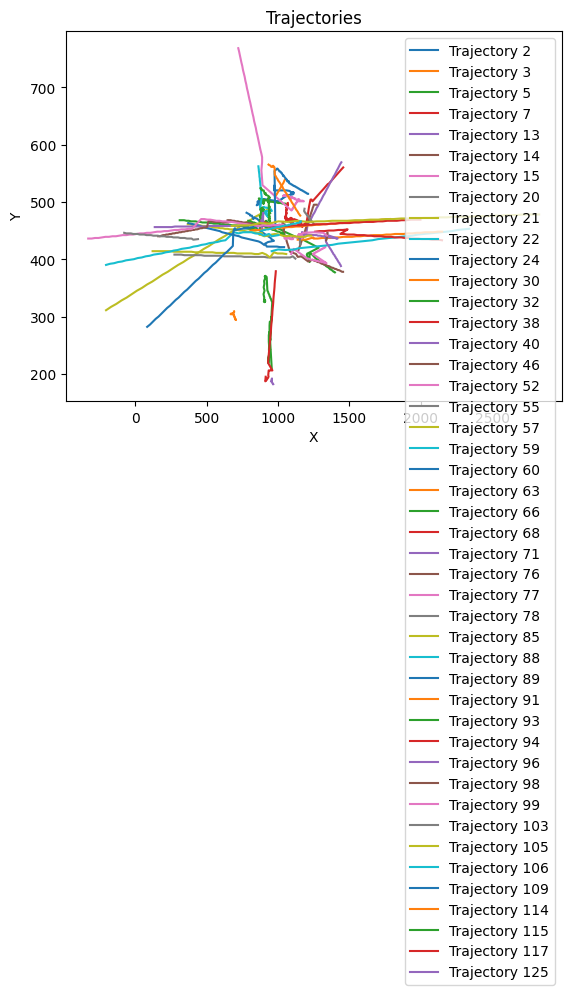

In [11]:
import matplotlib.pyplot as plt

# Example plotting all trajectories
for traj_id, points in trajectories.items():
    xs, ys = zip(*points)  # unzip into x and y coordinates
    plt.plot(xs, ys, label=f'Trajectory {traj_id}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectories')
plt.legend()
plt.show()

In [14]:
import cv2
from ultralytics import YOLO

# Load your detection model
model = YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt")  # Replace with your trained model path

# Load video
video_path = r"D:\Anti-UAV-RGBT\test\20190925_111757_1_1\visible.mp4"
cap = cv2.VideoCapture(video_path)

# Prepare output video writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("trajectory_video.mp4", fourcc, 30, 
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                       int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# List to store drone positions
positions = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect drones in the frame
    results = model(frame)
    
    # Assuming your model gives results in xyxy format and you take the first detection
    if len(results[0].boxes) > 0:
        box = results[0].boxes[0].xyxy[0]  # [x1, y1, x2, y2]
        x_center = int((box[0] + box[2]) / 2)
        y_center = int((box[1] + box[3]) / 2)
        positions.append((x_center, y_center))

    # Draw trajectory lines
    for i in range(1, len(positions)):
        cv2.line(frame, positions[i-1], positions[i], (0, 0, 255), 2)  # Red line

    # Show video
    cv2.imshow("Drone Trajectory", frame)
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 2 drones, 35.3ms
Speed: 5.8ms preprocess, 35.3ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 30.2ms
Speed: 3.4ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 30.4ms
Speed: 3.9ms preprocess, 30.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 30.6ms
Speed: 3.6ms preprocess, 30.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 30.5ms
Speed: 4.3ms preprocess, 30.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 30.3ms
Speed: 4.0ms preprocess, 30.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 drones, 30.3ms
Speed: 3.8ms preprocess, 30.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 drones, 15.2ms
Speed: 2.4ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 64

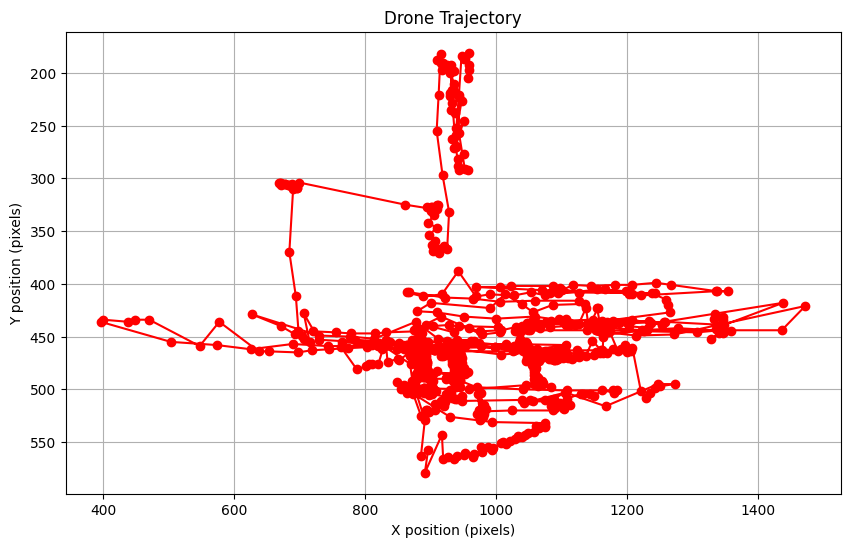

In [15]:
import matplotlib.pyplot as plt

# positions list should already have all (x, y) coordinates from previous snippet
x_coords = [pos[0] for pos in positions]
y_coords = [pos[1] for pos in positions]

plt.figure(figsize=(10, 6))
plt.plot(x_coords, y_coords, marker='o', color='red')
plt.title("Drone Trajectory")
plt.xlabel("X position (pixels)")
plt.ylabel("Y position (pixels)")
plt.gca().invert_yaxis()  # Invert Y-axis to match video coordinates
plt.grid(True)
plt.show()

In [5]:
import cv2
from ultralytics import YOLO

# Load your detection model
model = YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt")  # Replace with your trained model path

# Load video
video_path = r"D:\Anti-UAV-RGBT\test\20190925_111757_1_2\visible.mp4"
cap = cv2.VideoCapture(video_path)

# Prepare output video writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("trajectory_with_box.mp4", fourcc, 30, 
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                       int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# List to store drone positions
positions = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect drones in the frame
    results = model(frame)
    
    # If there is at least one detection
    if len(results[0].boxes) > 0:
        box = results[0].boxes[0].xyxy[0]  # [x1, y1, x2, y2]
        x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        
        # Draw bounding box around drone
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
        
        # Get center of the box for trajectory
        x_center = int((x1 + x2) / 2)
        y_center = int((y1 + y2) / 2)
        positions.append((x_center, y_center))

    # Draw trajectory lines
    for i in range(1, len(positions)):
        cv2.line(frame, positions[i-1], positions[i], (0, 0, 255), 2)  # Red line

    # Show video
    cv2.imshow("Drone Trajectory with Box", frame)
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 2 drones, 36.8ms
Speed: 5.4ms preprocess, 36.8ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 33.7ms
Speed: 5.2ms preprocess, 33.7ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 31.7ms
Speed: 4.1ms preprocess, 31.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 31.2ms
Speed: 6.8ms preprocess, 31.2ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 31.4ms
Speed: 5.5ms preprocess, 31.4ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 31.4ms
Speed: 5.0ms preprocess, 31.4ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.6ms
Speed: 4.7ms preprocess, 29.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.3ms
Speed: 4.3ms preprocess, 29.3ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

In [ ]:
import cv2
import math
from ultralytics import YOLO

# Load your detection model
model = YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt")  # Replace with your model path

# Load video
video_path = r"D:\Anti-UAV-RGBT\test\20190925_111757_1_2\visible.mp4"
cap = cv2.VideoCapture(video_path)

# Prepare output video writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("trajectory_with_box.mp4", fourcc, 30,
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                       int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# Store positions and stats
positions = []
total_frames = 0
frames_with_detection = 0

fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0:
    fps = 30  # default fallback

while True:
    ret, frame = cap.read()
    if not ret:
        break

    total_frames += 1
    results = model(frame)

    if len(results[0].boxes) > 0:
        frames_with_detection += 1
        box = results[0].boxes[0].xyxy[0]
        x1, y1, x2, y2 = map(int, box)
        x_center = int((x1 + x2) / 2)
        y_center = int((y1 + y2) / 2)
        positions.append((x_center, y_center))

        # Draw bounding box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Draw trajectory line
    for i in range(1, len(positions)):
        cv2.line(frame, positions[i-1], positions[i], (0, 0, 255), 2)

    cv2.imshow("Drone Trajectory with Box", frame)
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

# ----------------------------------------
# POST-PROCESSING: ANALYSIS & INSIGHTS
# ----------------------------------------

if len(positions) > 1:
    # Total distance traveled (in pixels)
    total_distance = sum(
        math.hypot(positions[i][0] - positions[i-1][0], positions[i][1] - positions[i-1][1])
        for i in range(1, len(positions))
    )

    # Duration
    duration_sec = total_frames / fps
    avg_speed = total_distance / duration_sec if duration_sec > 0 else 0

    # Start and end points
    start_x, start_y = positions[0]
    end_x, end_y = positions[-1]

    # Direction (based on start and end)
    dx = end_x - start_x
    dy = end_y - start_y

    if abs(dx) > abs(dy):
        if dx > 0:
            direction = "Left → Right"
        else:
            direction = "Right → Left"
    elif abs(dy) > abs(dx):
        if dy > 0:
            direction = "Top → Bottom"
        else:
            direction = "Bottom → Top"
    else:
        direction = "Diagonal"

    # Coverage area
    xs = [p[0] for p in positions]
    ys = [p[1] for p in positions]
    width = max(xs) - min(xs)
    height = max(ys) - min(ys)
    area_covered = width * height

    # Motion pattern
    straightness_threshold = 0.9  # 1 = perfectly straight
    direct_distance = math.hypot(dx, dy)
    path_ratio = direct_distance / total_distance if total_distance > 0 else 0

    if path_ratio > straightness_threshold:
        motion_pattern = "Straight flight"
    elif path_ratio < 0.4:
        motion_pattern = "Curved / circling motion"
    else:
        motion_pattern = "Partially curved flight"

    # Detection stats
    detection_rate = (frames_with_detection / total_frames) * 100 if total_frames > 0 else 0

    # ----------------------------------------
    # DISPLAY SUMMARY
    # ----------------------------------------
    print("\n================= DRONE TRAJECTORY ANALYSIS =================")
    print(f"Total frames processed: {total_frames}")
    print(f"Frames with drone detected: {frames_with_detection} ({detection_rate:.2f}%)")
    print("--------------------------------------------------------------")
    print(f"Movement Direction: {direction}")
    print(f"Total Distance Traveled: {total_distance:.2f} pixels")
    print(f"Average Speed: {avg_speed:.2f} pixels/sec")
    print(f"Motion Pattern: {motion_pattern}")
    print(f"Area Covered: {area_covered:.2f} px² (Width={width}, Height={height})")
    print("==============================================================\n")

else:
    print("⚠️ Not enough detections to analyze drone movement.")


0: 384x640 2 drones, 55.6ms
Speed: 7.2ms preprocess, 55.6ms inference, 31.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 69.0ms
Speed: 5.3ms preprocess, 69.0ms inference, 10.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 45.1ms
Speed: 4.2ms preprocess, 45.1ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 32.5ms
Speed: 4.6ms preprocess, 32.5ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 32.4ms
Speed: 4.3ms preprocess, 32.4ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 33.8ms
Speed: 67.6ms preprocess, 33.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 48.7ms
Speed: 4.6ms preprocess, 48.7ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 44.2ms
Speed: 7.0ms preprocess, 44.2ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 6

In [13]:
import cv2
import math
from ultralytics import YOLO
import matplotlib.pyplot as plt


class DroneTracker:
    def __init__(self, model_path, video_path, output_path="trajectory_with_box.mp4"):
        """Initialize model, video paths, and video writer."""
        self.model = YOLO(model_path)
        self.video_path = video_path
        self.output_path = output_path

        # Video setup
        self.cap = cv2.VideoCapture(video_path)
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30
        self.frame_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.frame_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Output video writer
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        self.out = cv2.VideoWriter(output_path, fourcc, 30, (self.frame_width, self.frame_height))

        # Tracking data
        self.positions = []
        self.total_frames = 0
        self.frames_with_detection = 0

    # ----------------------------------------
    # 1️⃣ FRAME PROCESSING
    # ----------------------------------------
    def process_frames(self):
        while True:
            ret, frame = self.cap.read()
            if not ret:
                break

            self.total_frames += 1
            self.detect_and_track(frame)

            cv2.imshow("Drone Trajectory with Box", frame)
            self.out.write(frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        self.cap.release()
        self.out.release()
        cv2.destroyAllWindows()

    # ----------------------------------------
    # 2️⃣ DETECTION & TRACKING
    # ----------------------------------------
    
    def detect_and_track(self, frame):
        results = self.model(frame)

        if len(results[0].boxes) > 0:
            self.frames_with_detection += 1
            box = results[0].boxes[0].xyxy[0]
            x1, y1, x2, y2 = map(int, box)
            x_center, y_center = int((x1 + x2) / 2), int((y1 + y2) / 2)
            self.positions.append((x_center, y_center))

            # Draw bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Draw trajectory (red line)
        for i in range(1, len(self.positions)):
            cv2.line(frame, self.positions[i - 1], self.positions[i], (0, 0, 255), 2)

    # ----------------------------------------
    # 3️⃣ ANALYSIS & INSIGHTS
    # ----------------------------------------
            
    def analyze_trajectory(self):
        """Compute drone motion statistics after tracking."""
        if len(self.positions) <= 1:
            print("⚠️ Not enough detections to analyze drone movement.")
            return None
        total_distance = sum(
            math.hypot(self.positions[i][0] - self.positions[i - 1][0],
                       self.positions[i][1] - self.positions[i - 1][1])
            for i in range(1, len(self.positions))
        )
        
        duration_sec = self.total_frames / self.fps
        avg_speed = total_distance / duration_sec if duration_sec > 0 else 0
        start_x, start_y = self.positions[0]
        end_x, end_y = self.positions[-1]
        dx, dy = end_x - start_x, end_y - start_y
        
        if abs(dx) > abs(dy):
            direction = "Left → Right" if dx > 0 else "Right → Left"
        elif abs(dy) > abs(dx):
            direction = "Top → Bottom" if dy > 0 else "Bottom → Top"
        else:
            direction = "Diagonal"
            
        xs = [p[0] for p in self.positions]
        ys = [p[1] for p in self.positions]
        width, height = max(xs) - min(xs), max(ys) - min(ys)
        area_covered = width * height
        direct_distance = math.hypot(dx, dy)
        path_ratio = direct_distance / total_distance if total_distance > 0 else 0
        if path_ratio > 0.9:
            motion_pattern = "Straight flight"
        elif path_ratio < 0.4:
            motion_pattern = "Curved / circling motion"
        else:
            motion_pattern = "Partially curved flight"
            
        detection_rate = (self.frames_with_detection / self.total_frames) * 100 if self.total_frames > 0 else 0
        
        summary = {
            "total_frames": self.total_frames,
            "frames_with_detection": self.frames_with_detection,
            "detection_rate": detection_rate,
            "direction": direction,
            "total_distance": total_distance,
            "avg_speed": avg_speed,
            "motion_pattern": motion_pattern,
            "area_covered": area_covered,
            "width": width,
            "height": height
        }

        self.print_summary(summary)
        return summary

    # ----------------------------------------
    # 4️⃣ SUMMARY PRINTER
    # ----------------------------------------
    
    def print_summary(self, summary):
        print("\n================= DRONE TRAJECTORY ANALYSIS =================")
        print(f"Total frames processed: {summary['total_frames']}")
        print(f"Frames with drone detected: {summary['frames_with_detection']} ({summary['detection_rate']:.2f}%)")
        print("--------------------------------------------------------------")
        print(f"Movement Direction: {summary['direction']}")
        print(f"Total Distance Traveled: {summary['total_distance']:.2f} pixels")
        print(f"Average Speed: {summary['avg_speed']:.2f} pixels/sec")
        print(f"Motion Pattern: {summary['motion_pattern']}")
        print(f"Area Covered: {summary['area_covered']:.2f} px² (Width={summary['width']}, Height={summary['height']})")
        print("==============================================================\n")

        # ----------------------------------------
    # 5️⃣ VISUALIZATION (Every 100 Frames)
    # ----------------------------------------
    def plot_trajectory(self):
        """Plot drone trajectory connecting only every 100th frame positions."""
        if len(self.positions) <= 1:
            print("⚠️ Not enough points to visualize trajectory.")
            return

        # ✅ Sample every 100th frame (use your defined interval)
        step = self.sample_interval
        sampled = self.positions[::step]

        if len(sampled) <= 1:
            print(f"⚠️ Not enough sampled points (interval={step}) to plot trajectory.")
            return

        xs = [p[0] for p in sampled]
        ys = [p[1] for p in sampled]

        plt.figure(figsize=(7, 7))
        plt.plot(xs, ys, '-o', color='red', label=f'Drone Path (every {step} frames)', markersize=6)
        plt.scatter(xs[0], ys[0], color='green', s=100, label='Start (Frame 0)')
        plt.scatter(xs[-1], ys[-1], color='blue', s=100, label=f'End (Frame {len(self.positions)})')
        plt.title(f'Drone Trajectory (Every {step} Frames)')
        plt.xlabel('X Position (pixels)')
        plt.ylabel('Y Position (pixels)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # ✅ Ensures plot is displayed even in scripts or notebooks
        plt.show(block=True)


# ==============================
# 🚀 RUNNING THE TRACKER
# ==============================
if __name__ == "__main__":
    tracker = DroneTracker(
        model_path=r"C:\Users\HP\runs\detect\train-city\weights\best.pt",
        video_path=r"D:\Anti-UAV-RGBT\test\20190925_124612_1_4\visible.mp4"
    )

    tracker.process_frames()          # 1. Run tracking on video
    summary = tracker.analyze_trajectory()  # 2. Analyze movement
    tracker.plot_trajectory()         # 3. Visualize trajectory


0: 384x640 (no detections), 35.1ms
Speed: 3.7ms preprocess, 35.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 33.2ms
Speed: 5.5ms preprocess, 33.2ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.3ms
Speed: 5.0ms preprocess, 29.3ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.0ms
Speed: 4.1ms preprocess, 29.0ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 28.8ms
Speed: 3.6ms preprocess, 28.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 28.8ms
Speed: 3.5ms preprocess, 28.8ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.2ms
Speed: 4.2ms preprocess, 29.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 27.5ms
Speed: 5.3ms preprocess, 27.5ms inference, 4.2ms postprocess per image at shape (

AttributeError: 'DroneTracker' object has no attribute 'sample_interval'

In [ ]:
import cv2
import math
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


class DroneTracker:
    def __init__(self, model_path, video_path, output_path="trajectory_with_box.mp4", sample_interval=100):
        """Initialize model, video paths, and video writer."""
        self.model = YOLO(model_path)
        self.video_path = video_path
        self.output_path = output_path
        self.sample_interval = sample_interval  # sample every N frames for plotting

        # Video setup
        self.cap = cv2.VideoCapture(video_path)
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30
        self.frame_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.frame_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Output video writer
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        self.out = cv2.VideoWriter(output_path, fourcc, 30, (self.frame_width, self.frame_height))

        # Tracking data
        self.positions = []            # all per-frame center points when detected
        self.sampled_positions = []    # centers sampled every sample_interval frames
        self.total_frames = 0
        self.frames_with_detection = 0

    # ----------------------------------------
    # 1️⃣ FRAME PROCESSING
    # ----------------------------------------
    def process_frames(self):
        while True:
            ret, frame = self.cap.read()
            if not ret:
                break

            self.total_frames += 1
            # detect_and_track still draws per-frame boxes and trajectory
            det_center = self.detect_and_track(frame)

            # If detection center returned and this frame is a sampling frame, store it
            if det_center is not None and (self.total_frames % self.sample_interval == 0):
                self.sampled_positions.append(det_center)

            cv2.imshow("Drone Trajectory with Box", frame)
            self.out.write(frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        self.cap.release()
        self.out.release()
        cv2.destroyAllWindows()

    # ----------------------------------------
    # 2️⃣ DETECTION & TRACKING
    # ----------------------------------------
    def detect_and_track(self, frame):
        """
        Returns:
            (x_center, y_center) if detection exists in this frame, else None.
        Side-effect: appends detection centers to self.positions and draws on frame.
        """
        results = self.model(frame)

        if len(results[0].boxes) > 0:
            self.frames_with_detection += 1
            box = results[0].boxes[0].xyxy[0]
            x1, y1, x2, y2 = map(int, box)
            x_center, y_center = int((x1 + x2) / 2), int((y1 + y2) / 2)
            self.positions.append((x_center, y_center))

            # Draw bounding box (green)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Return the center so caller can sample it if needed
            det_center = (x_center, y_center)
        else:
            det_center = None

        # Draw continuous trajectory (red) using positions (per-frame)
        for i in range(1, len(self.positions)):
            cv2.line(frame, self.positions[i - 1], self.positions[i], (0, 0, 255), 2)

        return det_center

    # ----------------------------------------
    # 3️⃣ ANALYSIS & INSIGHTS
    # ----------------------------------------
    def analyze_trajectory(self):
        """Compute drone motion statistics after tracking."""
        if len(self.positions) <= 1:
            print("⚠️ Not enough detections to analyze drone movement.")
            return None

        total_distance = sum(
            math.hypot(self.positions[i][0] - self.positions[i - 1][0],
                       self.positions[i][1] - self.positions[i - 1][1])
            for i in range(1, len(self.positions))
        )

        duration_sec = self.total_frames / self.fps
        avg_speed = total_distance / duration_sec if duration_sec > 0 else 0

        start_x, start_y = self.positions[0]
        end_x, end_y = self.positions[-1]
        dx, dy = end_x - start_x, end_y - start_y

        # Direction in North/South/East/West
        direction = self.get_cardinal_direction(dx, dy)

        xs = [p[0] for p in self.positions]
        ys = [p[1] for p in self.positions]
        width, height = max(xs) - min(xs), max(ys) - min(ys)
        area_covered = width * height
        direct_distance = math.hypot(dx, dy)
        path_ratio = direct_distance / total_distance if total_distance > 0 else 0

        if path_ratio > 0.9:
            motion_pattern = "Mostly straight flight path"
        elif path_ratio < 0.4:
            motion_pattern = "Highly curved or circling motion"
        else:
            motion_pattern = "Partially curved flight"

        detection_rate = (self.frames_with_detection / self.total_frames) * 100 if self.total_frames > 0 else 0

        summary = {
            "total_frames": self.total_frames,
            "frames_with_detection": self.frames_with_detection,
            "detection_rate": detection_rate,
            "direction": direction,
            "total_distance": total_distance,
            "avg_speed": avg_speed,
            "motion_pattern": motion_pattern,
            "area_covered": area_covered,
            "width": width,
            "height": height,
        }

        self.print_summary(summary)
        return summary

    # ----------------------------------------
    # Helper: Cardinal Direction
    # ----------------------------------------
    def get_cardinal_direction(self, dx, dy):
        """Convert dx, dy into cardinal direction like North, South-East, etc."""
        if abs(dx) < 5 and abs(dy) < 5:
            return "Stationary"
        horizontal = "East" if dx > 0 else "West"
        vertical = "South" if dy > 0 else "North"
        if abs(dx) > abs(dy):
            return horizontal
        elif abs(dy) > abs(dx):
            return vertical
        else:
            return f"{vertical}-{horizontal}"

    # ----------------------------------------
    # 4️⃣ SUMMARY PRINTER
    # ----------------------------------------
    def print_summary(self, summary):
        print("\n================= DRONE TRAJECTORY ANALYSIS =================")
        print(f"Total Frames Processed: {summary['total_frames']}")
        print(f"Frames with Drone Detection: {summary['frames_with_detection']} ({summary['detection_rate']:.2f}%)")
        print("--------------------------------------------------------------")
        print(f"Dominant Direction: {summary['direction']}")
        print(f"Total Distance Traveled: {summary['total_distance']:.2f} pixels")
        print(f"Average Speed: {summary['avg_speed']:.2f} pixels/sec")
        print(f"Motion Pattern: {summary['motion_pattern']}")
        print(f"Coverage Area: {summary['area_covered']:.2f} px² (Width={summary['width']}, Height={summary['height']})")
        print("==============================================================\n")

    # ----------------------------------------
    # 5️⃣ VISUALIZATION (Every sample_interval frames)
    # ----------------------------------------
    def plot_trajectory(self):
        """Show the full trajectory path using Matplotlib (sample every 100 frames)."""
        if len(self.positions) <= 1:
            print("⚠️ Not enough points to visualize trajectory.")
            return
    
        # ✅ Take every 100th point for a smoother overview
        sampled_positions = self.positions[::50]
    
        xs = [p[0] for p in sampled_positions]
        ys = [p[1] for p in sampled_positions]
    
        plt.figure(figsize=(6, 6))
        plt.plot(xs, ys, '-r', label='Drone Path (every 50 frames)')
        plt.scatter(xs[0], ys[0], color='green', label='Start', s=80)
        plt.scatter(xs[-1], ys[-1], color='blue', label='End', s=80)
        plt.title('Drone Trajectory Overview (Every 100 Frames)')
        plt.xlabel('X Position (pixels)')
        plt.ylabel('Y Position (pixels)')
        plt.legend()
        plt.grid(True)
        plt.show()


    def plot_speed_over_time(self):
        if len(self.positions) <= 1:
            print("Not enough data to plot speed over time.")
            return
    
        speeds = []
        for i in range(1, len(self.positions)):
            dx = self.positions[i][0] - self.positions[i-1][0]
            dy = self.positions[i][1] - self.positions[i-1][1]
            distance = math.hypot(dx, dy)
            speeds.append(distance * self.fps)  # pixels/sec
    
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(speeds)+1), speeds, '-b')
        plt.title("Drone Speed Over Time")
        plt.xlabel("Frame Number")
        plt.ylabel("Speed (pixels/sec)")
        plt.grid(True)
        plt.show()

    def plot_direction_distribution(self):
        if len(self.positions) <= 1:
            print("⚠️ Not enough data to plot direction distribution.")
            return
    
        directions = []
        for i in range(1, len(self.positions)):
            dx = self.positions[i][0] - self.positions[i-1][0]
            dy = self.positions[i][1] - self.positions[i-1][1]
            angle = math.atan2(dy, dx)
            directions.append(angle)
    
        plt.figure(figsize=(6, 6))
        plt.subplot(projection='polar')
        plt.hist(directions, bins=36, color='orange', alpha=0.7)
        plt.title("Drone Movement Direction Distribution")
        plt.show()

    def plot_heatmap(self):
        if len(self.positions) == 0:
            print("⚠️ No positions to generate heatmap.")
            return
    
        heatmap = np.zeros((self.frame_height, self.frame_width))
        for (x, y) in self.positions:
            if 0 <= x < self.frame_width and 0 <= y < self.frame_height:
                heatmap[y, x] += 1
    
        plt.figure(figsize=(8, 6))
        sns.heatmap(heatmap, cmap='plasma')
        plt.title("Drone Presence Heatmap")
        plt.xlabel("X Position (pixels)")
        plt.ylabel("Y Position (pixels)")
        plt.show()

    def plot_cumulative_distance(self):
        if len(self.positions) <= 1:
            print("⚠️ Not enough data to plot cumulative distance.")
            return
    
        distances = [0]
        for i in range(1, len(self.positions)):
            dx = self.positions[i][0] - self.positions[i-1][0]
            dy = self.positions[i][1] - self.positions[i-1][1]
            distances.append(distances[-1] + math.hypot(dx, dy))
    
        plt.figure(figsize=(8, 4))
        plt.plot(range(len(distances)), distances, '-g')
        plt.title("Cumulative Distance Covered Over Time")
        plt.xlabel("Frame Number")
        plt.ylabel("Distance (pixels)")
        plt.grid(True)
        plt.show()


        


# ==============================
# 🚀 RUNNING THE TRACKER
# ==============================

tracker = DroneTracker(
    model_path=r"C:\Users\HP\runs\detect\train-city\weights\best.pt",
    video_path=r"D:\Anti-UAV-RGBT\test\20190925_124612_1_4\visible.mp4",
    sample_interval=100
)

tracker.process_frames()                   # 1. Track on each frame (visual + output video)
summary = tracker.analyze_trajectory()     # 2. Analyze full motion


0: 384x640 (no detections), 198.6ms
Speed: 13.6ms preprocess, 198.6ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 35.5ms
Speed: 7.1ms preprocess, 35.5ms inference, 12.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 35.8ms
Speed: 5.6ms preprocess, 35.8ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 35.9ms
Speed: 5.5ms preprocess, 35.9ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 35.3ms
Speed: 6.9ms preprocess, 35.3ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 63.6ms
Speed: 6.3ms preprocess, 63.6ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 36.0ms
Speed: 7.5ms preprocess, 36.0ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 35.4ms
Speed: 5.6ms preprocess, 35.4ms inference, 6.7ms postprocess per image at sh

In [2]:
import cv2
import math
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


class DroneTracker:
    def __init__(self, model_path, video_path, output_path="trajectory_with_box.mp4", sample_interval=100):
        """Initialize model, video paths, and video writer."""
        self.model = YOLO(model_path)
        self.video_path = video_path
        self.output_path = output_path
        self.sample_interval = sample_interval  # sample every N frames for plotting

        # Video setup
        self.cap = cv2.VideoCapture(video_path)
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30
        self.frame_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.frame_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Output video writer
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        self.out = cv2.VideoWriter(output_path, fourcc, 30, (self.frame_width, self.frame_height))

        # Tracking data
        self.positions = []            # all per-frame center points when detected
        self.sampled_positions = []    # centers sampled every sample_interval frames
        self.total_frames = 0
        self.frames_with_detection = 0

    # ----------------------------------------
    # 1️⃣ FRAME PROCESSING
    # ----------------------------------------
    def process_frames(self):
        while True:
            ret, frame = self.cap.read()
            if not ret:
                break

            self.total_frames += 1
            # detect_and_track still draws per-frame boxes and trajectory
            det_center = self.detect_and_track(frame)

            # If detection center returned and this frame is a sampling frame, store it
            if det_center is not None and (self.total_frames % self.sample_interval == 0):
                self.sampled_positions.append(det_center)

            cv2.imshow("Drone Trajectory with Box", frame)
            self.out.write(frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        self.cap.release()
        self.out.release()
        cv2.destroyAllWindows()

    # ----------------------------------------
    # 2️⃣ DETECTION & TRACKING
    # ----------------------------------------
    def detect_and_track(self, frame):
        """
        Returns:
            (x_center, y_center) if detection exists in this frame, else None.
        Side-effect: appends detection centers to self.positions and draws on frame.
        """
        results = self.model(frame)

        if len(results[0].boxes) > 0:
            self.frames_with_detection += 1
            box = results[0].boxes[0].xyxy[0]
            x1, y1, x2, y2 = map(int, box)
            x_center, y_center = int((x1 + x2) / 2), int((y1 + y2) / 2)
            self.positions.append((x_center, y_center))

            # Draw bounding box (green)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Return the center so caller can sample it if needed
            det_center = (x_center, y_center)
        else:
            det_center = None

        # Draw continuous trajectory (red) using positions (per-frame)
        for i in range(1, len(self.positions)):
            cv2.line(frame, self.positions[i - 1], self.positions[i], (0, 0, 255), 2)

        return det_center

    # ----------------------------------------
    # 3️⃣ ANALYSIS & INSIGHTS
    # ----------------------------------------
    def analyze_trajectory(self):
        """Compute drone motion statistics after tracking."""
        if len(self.positions) <= 1:
            print("⚠️ Not enough detections to analyze drone movement.")
            return None

        total_distance = sum(
            math.hypot(self.positions[i][0] - self.positions[i - 1][0],
                       self.positions[i][1] - self.positions[i - 1][1])
            for i in range(1, len(self.positions))
        )

        duration_sec = self.total_frames / self.fps
        avg_speed = total_distance / duration_sec if duration_sec > 0 else 0

        start_x, start_y = self.positions[0]
        end_x, end_y = self.positions[-1]
        dx, dy = end_x - start_x, end_y - start_y

        # Direction in North/South/East/West
        direction = self.get_cardinal_direction(dx, dy)

        xs = [p[0] for p in self.positions]
        ys = [p[1] for p in self.positions]
        width, height = max(xs) - min(xs), max(ys) - min(ys)
        area_covered = width * height
        direct_distance = math.hypot(dx, dy)
        path_ratio = direct_distance / total_distance if total_distance > 0 else 0

        if path_ratio > 0.9:
            motion_pattern = "Mostly straight flight path"
        elif path_ratio < 0.4:
            motion_pattern = "Highly curved or circling motion"
        else:
            motion_pattern = "Partially curved flight"

        detection_rate = (self.frames_with_detection / self.total_frames) * 100 if self.total_frames > 0 else 0

        summary = {
            "total_frames": self.total_frames,
            "frames_with_detection": self.frames_with_detection,
            "detection_rate": detection_rate,
            "direction": direction,
            "total_distance": total_distance,
            "avg_speed": avg_speed,
            "motion_pattern": motion_pattern,
            "area_covered": area_covered,
            "width": width,
            "height": height,
        }

        self.print_summary(summary)
        return summary

    # ----------------------------------------
    # Helper: Cardinal Direction
    # ----------------------------------------
    def get_cardinal_direction(self, dx, dy):
        """Convert dx, dy into cardinal direction like North, South-East, etc."""
        if abs(dx) < 5 and abs(dy) < 5:
            return "Stationary"
        horizontal = "East" if dx > 0 else "West"
        vertical = "South" if dy > 0 else "North"
        if abs(dx) > abs(dy):
            return horizontal
        elif abs(dy) > abs(dx):
            return vertical
        else:
            return f"{vertical}-{horizontal}"

    # ----------------------------------------
    # 4️⃣ SUMMARY PRINTER
    # ----------------------------------------
    def print_summary(self, summary):
        print("\n================= DRONE TRAJECTORY ANALYSIS =================")
        print(f"Total Frames Processed: {summary['total_frames']}")
        print(f"Frames with Drone Detection: {summary['frames_with_detection']} ({summary['detection_rate']:.2f}%)")
        print("--------------------------------------------------------------")
        print(f"Dominant Direction: {summary['direction']}")
        print(f"Total Distance Traveled: {summary['total_distance']:.2f} pixels")
        print(f"Average Speed: {summary['avg_speed']:.2f} pixels/sec")
        print(f"Motion Pattern: {summary['motion_pattern']}")
        print(f"Coverage Area: {summary['area_covered']:.2f} px² (Width={summary['width']}, Height={summary['height']})")
        print("==============================================================\n")

    # ----------------------------------------
    # 5️⃣ VISUALIZATION (Every sample_interval frames)
    # ----------------------------------------
    def plot_trajectory(self):
        """Show the full trajectory path using Matplotlib (sample every 100 frames)."""
        if len(self.positions) <= 1:
            print("⚠️ Not enough points to visualize trajectory.")
            return
    
        # ✅ Take every 100th point for a smoother overview
        sampled_positions = self.positions[::50]
    
        xs = [p[0] for p in sampled_positions]
        ys = [p[1] for p in sampled_positions]
    
        plt.figure(figsize=(6, 6))
        plt.plot(xs, ys, '-r', label='Drone Path (every 50 frames)')
        plt.scatter(xs[0], ys[0], color='green', label='Start', s=80)
        plt.scatter(xs[-1], ys[-1], color='blue', label='End', s=80)
        plt.title('Drone Trajectory Overview (Every 50 Frames)')
        plt.xlabel('X Position (pixels)')
        plt.ylabel('Y Position (pixels)')
        plt.legend()
        plt.grid(True)
        plt.show()


    def plot_speed_over_time(self):
        if len(self.positions) <= 1:
            print("Not enough data to plot speed over time.")
            return
    
        speeds = []
        for i in range(1, len(self.positions)):
            dx = self.positions[i][0] - self.positions[i-1][0]
            dy = self.positions[i][1] - self.positions[i-1][1]
            distance = math.hypot(dx, dy)
            speeds.append(distance * self.fps)  # pixels/sec
    
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(speeds)+1), speeds, '-b')
        plt.title("Drone Speed Over Time")
        plt.xlabel("Frame Number")
        plt.ylabel("Speed (pixels/sec)")
        plt.grid(True)
        plt.show()

    def plot_direction_distribution(self):
        if len(self.positions) <= 1:
            print("⚠️ Not enough data to plot direction distribution.")
            return
    
        directions = []
        for i in range(1, len(self.positions)):
            dx = self.positions[i][0] - self.positions[i-1][0]
            dy = self.positions[i][1] - self.positions[i-1][1]
            angle = math.atan2(dy, dx)
            directions.append(angle)
    
        plt.figure(figsize=(6, 6))
        plt.subplot(projection='polar')
        plt.hist(directions, bins=36, color='orange', alpha=0.7)
        plt.title("Drone Movement Direction Distribution")
        plt.show()

    def plot_heatmap(self):
        if len(self.positions) == 0:
            print("⚠️ No positions to generate heatmap.")
            return
    
        heatmap = np.zeros((self.frame_height, self.frame_width))
        for (x, y) in self.positions:
            if 0 <= x < self.frame_width and 0 <= y < self.frame_height:
                heatmap[y, x] += 1
    
        plt.figure(figsize=(8, 6))
        sns.heatmap(heatmap, cmap='plasma')
        plt.title("Drone Presence Heatmap")
        plt.xlabel("X Position (pixels)")
        plt.ylabel("Y Position (pixels)")
        plt.show()

    def plot_cumulative_distance(self):
        if len(self.positions) <= 1:
            print("⚠️ Not enough data to plot cumulative distance.")
            return
    
        distances = [0]
        for i in range(1, len(self.positions)):
            dx = self.positions[i][0] - self.positions[i-1][0]
            dy = self.positions[i][1] - self.positions[i-1][1]
            distances.append(distances[-1] + math.hypot(dx, dy))
    
        plt.figure(figsize=(8, 4))
        plt.plot(range(len(distances)), distances, '-g')
        plt.title("Cumulative Distance Covered Over Time")
        plt.xlabel("Frame Number")
        plt.ylabel("Distance (pixels)")
        plt.grid(True)
        plt.show()


        


# ==============================
# 🚀 RUNNING THE TRACKER
# ==============================

tracker = DroneTracker(
    model_path=r"C:\Users\HP\runs\detect\new-train-all\train-city\weights\best.pt",
    video_path=r"D:\Anti-UAV-RGBT\test\20190926_134054_1_9\visible.mp4",
    sample_interval=100
)

tracker.process_frames()                   # 1. Track on each frame (visual + output video)
summary = tracker.analyze_trajectory()     # 2. Analyze full motion


0: 384x640 1 drone, 33.6ms
Speed: 6.1ms preprocess, 33.6ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.4ms
Speed: 6.8ms preprocess, 29.4ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.9ms
Speed: 6.6ms preprocess, 29.9ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.4ms
Speed: 5.7ms preprocess, 29.4ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.4ms
Speed: 5.4ms preprocess, 29.4ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 30.0ms
Speed: 5.7ms preprocess, 30.0ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.9ms
Speed: 6.4ms preprocess, 29.9ms inference, 7.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 29.4ms
Speed: 6.0ms preprocess, 29.4ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


In [3]:
import cv2
import math
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


class DroneTracker:
    def __init__(self, model_path, video_path, output_path="trajectory_with_box.mp4", sample_interval=100):
        """Initialize model, video paths, and video writer."""
        self.model = YOLO(model_path)
        self.video_path = video_path
        self.output_path = output_path
        self.sample_interval = sample_interval  # sample every N frames for plotting

        # Video setup
        self.cap = cv2.VideoCapture(video_path)
        self.fps = self.cap.get(cv2.CAP_PROP_FPS) or 30
        self.frame_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.frame_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Output video writer
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        self.out = cv2.VideoWriter(output_path, fourcc, 30, (self.frame_width, self.frame_height))

        # Tracking data
        self.positions = []            # all per-frame center points when detected
        self.sampled_positions = []    # centers sampled every sample_interval frames
        self.total_frames = 0
        self.frames_with_detection = 0

    # ----------------------------------------
    # 1️⃣ FRAME PROCESSING
    # ----------------------------------------
    def process_frames(self):
        while True:
            ret, frame = self.cap.read()
            if not ret:
                break

            self.total_frames += 1
            # detect_and_track still draws per-frame boxes and trajectory
            det_center = self.detect_and_track(frame)

            # If detection center returned and this frame is a sampling frame, store it
            if det_center is not None and (self.total_frames % self.sample_interval == 0):
                self.sampled_positions.append(det_center)

            cv2.imshow("Drone Trajectory with Box", frame)
            self.out.write(frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        self.cap.release()
        self.out.release()
        cv2.destroyAllWindows()

    # ----------------------------------------
    # 2️⃣ DETECTION & TRACKING
    # ----------------------------------------
    def detect_and_track(self, frame):
        """
        Returns:
            (x_center, y_center) if detection exists in this frame, else None.
        Side-effect: appends detection centers to self.positions and draws on frame.
        """
        results = self.model(frame)

        if len(results[0].boxes) > 0:
            self.frames_with_detection += 1
            box = results[0].boxes[0].xyxy[0]
            x1, y1, x2, y2 = map(int, box)
            x_center, y_center = int((x1 + x2) / 2), int((y1 + y2) / 2)
            self.positions.append((x_center, y_center))

            # Draw bounding box (green)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Return the center so caller can sample it if needed
            det_center = (x_center, y_center)
        else:
            det_center = None

        # Dynamic gradient line (blue → green → yellow → red)
        for i in range(1, len(self.positions)):
            ratio = i / len(self.positions)
            color = (
                int(255 * min(1, 2 * ratio)),        # R
                int(255 * (1 - abs(2 * ratio - 1))), # G
                int(255 * (1 - ratio))               # B
            )
            cv2.line(frame, self.positions[i - 1], self.positions[i], color, 2)

        return det_center

    # ----------------------------------------
    # 3️⃣ ANALYSIS & INSIGHTS
    # ----------------------------------------
    def analyze_trajectory(self):
        """Compute drone motion statistics after tracking."""
        if len(self.positions) <= 1:
            print("⚠️ Not enough detections to analyze drone movement.")
            return None

        total_distance = sum(
            math.hypot(self.positions[i][0] - self.positions[i - 1][0],
                       self.positions[i][1] - self.positions[i - 1][1])
            for i in range(1, len(self.positions))
        )

        duration_sec = self.total_frames / self.fps
        avg_speed = total_distance / duration_sec if duration_sec > 0 else 0

        start_x, start_y = self.positions[0]
        end_x, end_y = self.positions[-1]
        dx, dy = end_x - start_x, end_y - start_y

        # Direction in North/South/East/West
        direction = self.get_cardinal_direction(dx, dy)

        xs = [p[0] for p in self.positions]
        ys = [p[1] for p in self.positions]
        width, height = max(xs) - min(xs), max(ys) - min(ys)
        area_covered = width * height
        direct_distance = math.hypot(dx, dy)
        path_ratio = direct_distance / total_distance if total_distance > 0 else 0

        if path_ratio > 0.9:
            motion_pattern = "Mostly straight flight path"
        elif path_ratio < 0.4:
            motion_pattern = "Highly curved or circling motion"
        else:
            motion_pattern = "Partially curved flight"

        detection_rate = (self.frames_with_detection / self.total_frames) * 100 if self.total_frames > 0 else 0

        summary = {
            "total_frames": self.total_frames,
            "frames_with_detection": self.frames_with_detection,
            "detection_rate": detection_rate,
            "direction": direction,
            "total_distance": total_distance,
            "avg_speed": avg_speed,
            "motion_pattern": motion_pattern,
            "area_covered": area_covered,
            "width": width,
            "height": height,
        }

        self.print_summary(summary)
        return summary

    def get_cardinal_direction(self, dx, dy):
        """Convert dx, dy into cardinal direction like North, South-East, etc."""
        if abs(dx) < 5 and abs(dy) < 5:
            return "Stationary"
        horizontal = "East" if dx > 0 else "West"
        vertical = "South" if dy > 0 else "North"
        if abs(dx) > abs(dy):
            return horizontal
        elif abs(dy) > abs(dx):
            return vertical
        else:
            return f"{vertical}-{horizontal}"

    def print_summary(self, summary):
        print("\n================= DRONE TRAJECTORY ANALYSIS =================")
        print(f"Total Frames Processed: {summary['total_frames']}")
        print(f"Frames with Drone Detection: {summary['frames_with_detection']} ({summary['detection_rate']:.2f}%)")
        print("--------------------------------------------------------------")
        print(f"Dominant Direction: {summary['direction']}")
        print(f"Total Distance Traveled: {summary['total_distance']:.2f} pixels")
        print(f"Average Speed: {summary['avg_speed']:.2f} pixels/sec")
        print(f"Motion Pattern: {summary['motion_pattern']}")
        print(f"Coverage Area: {summary['area_covered']:.2f} px² (Width={summary['width']}, Height={summary['height']})")
        print("==============================================================\n")


    def plot_trajectory(self):
        """Show the full trajectory path using Matplotlib (sample every 100 frames)."""
        if len(self.positions) <= 1:
            print("Not enough points to visualize trajectory.")
            return
    
        # Take every 100th point for a smoother overview
        sampled_positions = self.positions[::50]
    
        xs = [p[0] for p in sampled_positions]
        ys = [p[1] for p in sampled_positions]
    
        plt.figure(figsize=(6, 6))
        plt.plot(xs, ys, '-r', label='Drone Path (every 50 frames)')
        plt.scatter(xs[0], ys[0], color='green', label='Start', s=80)
        plt.scatter(xs[-1], ys[-1], color='blue', label='End', s=80)
        plt.title('Drone Trajectory Overview (Every 50 Frames)')
        plt.xlabel('X Position (pixels)')
        plt.ylabel('Y Position (pixels)')
        plt.legend()
        plt.grid(True)
        plt.show()


    def plot_speed_over_time(self):
        if len(self.positions) <= 1:
            print("Not enough data to plot speed over time.")
            return
    
        speeds = []
        for i in range(1, len(self.positions)):
            dx = self.positions[i][0] - self.positions[i-1][0]
            dy = self.positions[i][1] - self.positions[i-1][1]
            distance = math.hypot(dx, dy)
            speeds.append(distance * self.fps)  # pixels/sec
    
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(speeds)+1), speeds, '-b')
        plt.title("Drone Speed Over Time")
        plt.xlabel("Frame Number")
        plt.ylabel("Speed (pixels/sec)")
        plt.grid(True)
        plt.show()

    def plot_direction_distribution(self):
        if len(self.positions) <= 1:
            print("Not enough data to plot direction distribution.")
            return
    
        directions = []
        for i in range(1, len(self.positions)):
            dx = self.positions[i][0] - self.positions[i-1][0]
            dy = self.positions[i][1] - self.positions[i-1][1]
            angle = math.atan2(dy, dx)
            directions.append(angle)
    
        plt.figure(figsize=(6, 6))
        plt.subplot(projection='polar')
        plt.hist(directions, bins=36, color='orange', alpha=0.7)
        plt.title("Drone Movement Direction Distribution")
        plt.show()

    def plot_heatmap(self):
        if len(self.positions) == 0:
            print("⚠️ No positions to generate heatmap.")
            return
    
        heatmap = np.zeros((self.frame_height, self.frame_width))
        for (x, y) in self.positions:
            if 0 <= x < self.frame_width and 0 <= y < self.frame_height:
                heatmap[y, x] += 1
    
        plt.figure(figsize=(8, 6))
        sns.heatmap(heatmap, cmap='plasma')
        plt.title("Drone Presence Heatmap")
        plt.xlabel("X Position (pixels)")
        plt.ylabel("Y Position (pixels)")
        plt.show()

    def plot_cumulative_distance(self):
        if len(self.positions) <= 1:
            print("⚠️ Not enough data to plot cumulative distance.")
            return
    
        distances = [0]
        for i in range(1, len(self.positions)):
            dx = self.positions[i][0] - self.positions[i-1][0]
            dy = self.positions[i][1] - self.positions[i-1][1]
            distances.append(distances[-1] + math.hypot(dx, dy))
    
        plt.figure(figsize=(8, 4))
        plt.plot(range(len(distances)), distances, '-g')
        plt.title("Cumulative Distance Covered Over Time")
        plt.xlabel("Frame Number")
        plt.ylabel("Distance (pixels)")
        plt.grid(True)
        plt.show()


tracker = DroneTracker(
    model_path=r"C:\Users\HP\runs\detect\new-train-all\train-city\weights\best.pt",
    video_path=r"D:\Anti-UAV-RGBT\test\20190926_134054_1_8\infrared.mp4",
    sample_interval=100
)

tracker.process_frames()                   # 1. Track on each frame (visual + output video)
summary = tracker.analyze_trajectory()     # 2. Analyze full motion


0: 512x640 1 drone, 104.7ms
Speed: 10.7ms preprocess, 104.7ms inference, 365.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 drone, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 3.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 drone, 18.1ms
Speed: 2.2ms preprocess, 18.1ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 drone, 21.3ms
Speed: 3.1ms preprocess, 21.3ms inference, 3.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 drone, 18.8ms
Speed: 3.1ms preprocess, 18.8ms inference, 3.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 drone, 19.1ms
Speed: 2.9ms preprocess, 19.1ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 drone, 17.2ms
Speed: 3.2ms preprocess, 17.2ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 drone, 16.2ms
Speed: 2.4ms preprocess, 16.2ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 

In [27]:
%matplotlib inline

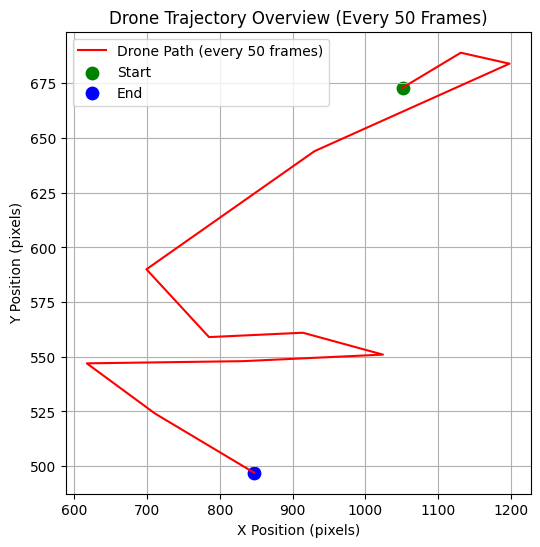

In [47]:
tracker.plot_trajectory() 

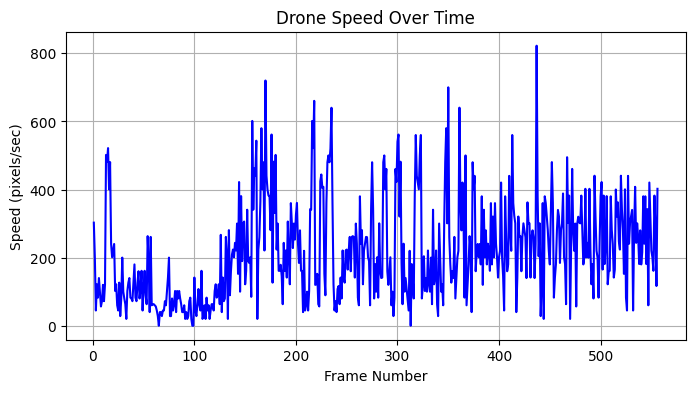

In [38]:
tracker.plot_speed_over_time()

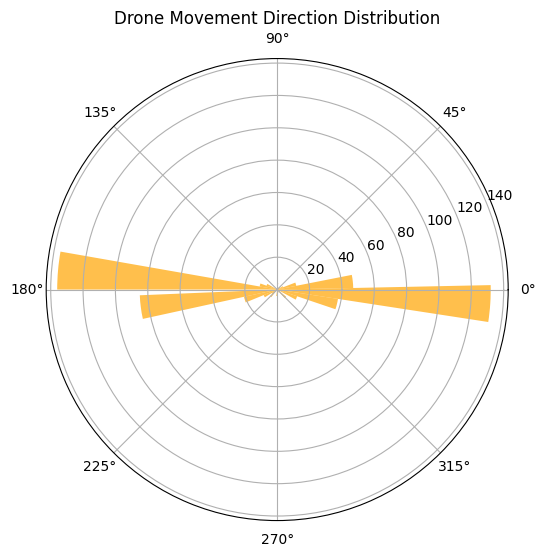

In [39]:
tracker.plot_direction_distribution()

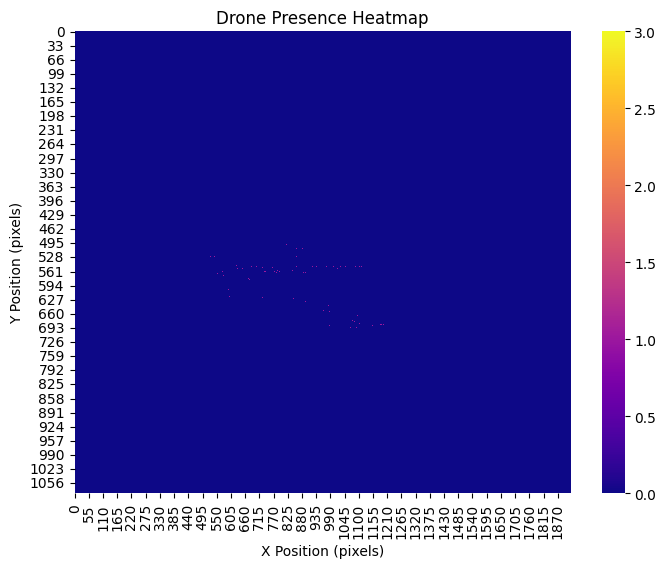

In [40]:
tracker.plot_heatmap()

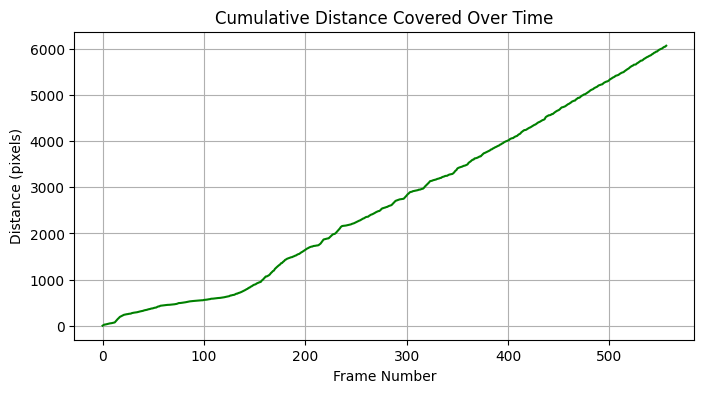

In [41]:
tracker.plot_cumulative_distance()

In [1]:
from ultralytics import YOLO
import numpy as np

# Load your fine-tuned model
model = YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt")

# Evaluate on validation dataset
results = model.val(
    data=r"D:\Anti-UAV-RGBT\data.yml",
    imgsz=640,
    conf=0.25,
    iou=0.6,
    split='val',
    save_json=True,
    plots=True,   # Saves PR curve, confusion matrix, etc.
    save_hybrid=True
)

# --- Extract metrics safely ---
precision = results.box.p.mean() if isinstance(results.box.p, np.ndarray) else results.box.p
recall = results.box.r.mean() if isinstance(results.box.r, np.ndarray) else results.box.r
map50 = results.box.map50.mean() if isinstance(results.box.map50, np.ndarray) else results.box.map50
map5095 = results.box.map.mean() if isinstance(results.box.map, np.ndarray) else results.box.map

# Compute F1 score
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

# --- Print key metrics ---
print("\n--- Evaluation Metrics ---")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"mAP@0.5: {map50:.4f}")
print(f"mAP@0.5:0.95: {map5095:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\n✅ All result plots (confusion matrix, PR curve, etc.) are saved in:")
print(results.save_dir)

WARNING 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.188  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.30.1 ms, read: 20.012.0 MB/s, size: 101.7 KB)
val: Scanning D:\Anti-UAV-RGBT\frames\val\labels\infrared_flat.cache... 3798 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3798/3798  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 238/238 4.9it/s 48.6s
                   all       3798       3798      0.825      0.242       0.49       0.35
Speed: 0.3ms preprocess, 5.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Saving runs\detect\val44\predictions.json...
Results saved to runs\detect\val44

--- Evaluation Metrics ---
Precision: 0.8252
Recall: 0.2425
mAP@0.5: 0.4900
mAP@0.5:0.95: 0.3502
F1 Score: 0.3748

✅ All result plots

In [ ]:
from ultralytics import YOLO

model = YOLO(r"C:\Users\HP\runs\detect\train-city\weights\best.pt")

model.train(
    data=r"D:\Anti-UAV-RGBT\data.yml",
    epochs=30,
    patience=20,
    imgsz=640,
    batch=8,
    lr0=1e-4,
    project="anti_uav_training",
    name="finetuned_model_multimodal"
)

New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.188  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Anti-UAV-RGBT\data.yml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=C:\Users\HP\runs\detect\train-city\weights\best.pt, momentum=0.937, mosaic=1.0, multi_scale=Fa

In [1]:
import os
import cv2

# Path to your dataset (train + val)
label_root = r"D:\Anti-UAV-RGBT\frames"
image_subdirs = ["train", "val"]

for subdir in image_subdirs:
    for mode in ["visible_flat", "infrared_flat"]:
        label_dir = os.path.join(label_root, subdir, "labels", mode)
        image_dir = os.path.join(label_root, subdir, "images", mode)
        
        if not os.path.exists(label_dir):
            continue

        for label_file in os.listdir(label_dir):
            if not label_file.endswith(".txt"):
                continue

            label_path = os.path.join(label_dir, label_file)
            image_path_jpg = os.path.join(image_dir, label_file.replace(".txt", ".jpg"))
            image_path_png = os.path.join(image_dir, label_file.replace(".txt", ".png"))

            if os.path.exists(image_path_jpg):
                img_path = image_path_jpg
            elif os.path.exists(image_path_png):
                img_path = image_path_png
            else:
                print(f"No image found for {label_file}")
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"Unable to read image {img_path}")
                continue
            h, w = img.shape[:2]

            new_lines = []
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    cls, x, y, bw, bh = parts
                    x, y, bw, bh = map(float, (x, y, bw, bh))

                    # If already normalized, skip
                    if x <= 1 and y <= 1 and bw <= 1 and bh <= 1:
                        new_lines.append(line.strip())
                        continue

                    # Convert from pixel coords to normalized
                    x /= w
                    y /= h
                    bw /= w
                    bh /= h

                    # Keep within [0,1]
                    x, y = min(max(x, 0), 1), min(max(y, 0), 1)
                    bw, bh = min(max(bw, 0), 1), min(max(bh, 0), 1)

                    new_lines.append(f"{cls} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}")

            with open(label_path, "w") as f:
                f.write("\n".join(new_lines))

            print(f"Normalized {label_file}")

Normalized 20190925_101846_1_7_0000.txt
Normalized 20190925_101846_1_7_0001.txt
Normalized 20190925_101846_1_7_0002.txt
Normalized 20190925_101846_1_7_0003.txt
Normalized 20190925_101846_1_7_0004.txt
Normalized 20190925_101846_1_7_0005.txt
Normalized 20190925_101846_1_7_0006.txt
Normalized 20190925_101846_1_7_0007.txt
Normalized 20190925_101846_1_7_0008.txt
Normalized 20190925_101846_1_7_0009.txt
Normalized 20190925_101846_1_7_0010.txt
Normalized 20190925_101846_1_7_0011.txt
Normalized 20190925_101846_1_7_0012.txt
Normalized 20190925_101846_1_7_0013.txt
Normalized 20190925_101846_1_7_0014.txt
Normalized 20190925_101846_1_7_0015.txt
Normalized 20190925_101846_1_7_0016.txt
Normalized 20190925_101846_1_7_0017.txt
Normalized 20190925_101846_1_7_0018.txt
Normalized 20190925_101846_1_7_0019.txt
Normalized 20190925_101846_1_7_0020.txt
Normalized 20190925_101846_1_7_0021.txt
Normalized 20190925_101846_1_7_0022.txt
Normalized 20190925_101846_1_7_0023.txt
Normalized 20190925_101846_1_7_0024.txt


In [8]:
from ultralytics import YOLO

model = YOLO(r"C:\Users\HP\runs\detect\new-train-all\train-city\weights\best.pt")
model.info(verbose=True)

Model summary: 129 layers, 3,011,043 parameters, 0 gradients, 8.2 GFLOPs


(129, 3011043, 0, 8.1941504)

In [9]:
!D:\conda_envs\drone-gpu\python.exe -m pip install torchsummary


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: D:\conda_envs\drone-gpu\python.exe -m pip install --upgrade pip


In [10]:
from ultralytics import YOLO
from torchsummary import summary

model = YOLO(r"C:\Users\HP\runs\detect\new-train-all\train-city\weights\best.pt")
torch_model = model.model  # access underlying PyTorch model
summary(torch_model, input_size=(3, 640, 640))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [11]:
!pip install prettytable rich


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
